In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
from IPython.core.display import display, HTML
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import pandas as pd
import argparse, logging, tempfile, json, sys, pandas
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.max_open_warning'] = 50
display(HTML("<style>.container { width:100% !important; }</style>"))
from trace_utils import *

In [4]:
# %%capture
# with open("../data/trace_trimmed.json") as f:
#     trace = json.load(f)
    
# trace_file = '../data/DLRM_default_1.json'
# trim_trace_by_time(trace_file, 1617835332719386, 1617835333095406)
# with open("../data/trace_trimmed.json") as f:
#     trace = json.load(f)

trace_file = '../data/MLPerf_1.json'
trim_trace_by_time(trace_file, 1617835925909919, 1617835926084651)
with open("../data/trace_trimmed.json") as f:
    trace = json.load(f)

## DLRM with data loading

In [5]:
roots, cc, corrected_start_time, corrected_end_time, sum_skipped_intervals = process_event_hierarchy(trace['traceEvents'], skip_module=False)
print('Num of events: {}, num of root events: {}, num of caller/callee pairs: {}'.format(len(trace['traceEvents']), len(roots), len(cc)))
print('Sum of dataloading time: {}'.format(sum_skipped_intervals))
print("Corrected start time: ", corrected_start_time, ", corrected end time: ", corrected_end_time)
host_runtime = corrected_end_time - corrected_start_time - sum_skipped_intervals
# ---
# device_runtime, device_start_delay = get_device_runtime_and_start_delay(cc, corrected_start_time)
# print("Device start delay: ", device_start_delay)
# ---
device_runtime = host_runtime
# ---
print("Host runtime: ", host_runtime)
print("Device runtime: ", device_runtime)
ops = []
get_operators(roots, ops)
QPS = 1000000 / host_runtime * 10 * 2048
print(f"QPS: {QPS:.2f}")

Num of events: 18015, num of root events: 158, num of caller/callee pairs: 6234
Sum of dataloading time: 60774
Corrected start time:  1617835925909919 , corrected end time:  1617835926084654
Host runtime:  113961
Device runtime:  113961
QPS: 179710.60


### Host runtime breakdown

In [6]:
depth_limit = 3
truncate_count = 3
host_runtime_breakdown = get_host_runtime_breakdown(roots, cc, host_runtime)
print_host_results(host_runtime_breakdown, depth_limit, truncate_count)

Two iteration runtime:               113961 (in us, same below)
     module::backward_pass:                     (52160.0, 45.77%, 10)
          AddmmBackward:                                  (16190.0, 31.04%, 80)
               aten::mm:                                             (9793.0, 60.49%, 150)
                    cudaLaunchKernel:                                          (1755.0, 17.92%, 180)
                    aten::empty:                                               (1028.0, 10.50%, 150)
                    cudaMemsetAsync:                                            (628.0, 6.41%, 90)
                    Others:                                                     (735.0, 7.51%)
                    Unaccounted:                                               (5647.0, 57.66%)
               aten::t:                                              (3423.0, 21.14%, 230)
                    aten::transpose:                                           (1934.0, 56.50%, 230)
           

In [7]:
op_device_runtime = get_device_runtime(ops, cc) # dict: op ex_id -> all its device calls and stats
pprint(op_device_runtime)

{94142: {7: {('Memcpy HtoD (Pageable -> Device)', ((53248,), (53248,), ())): {'count': 1,
                                                                              'runtime': 20.0}}},
 94145: {7: {('Memcpy HtoD (Pageable -> Device)', ((53249,), (53249,), ())): {'count': 1,
                                                                              'runtime': 20.0}}},
 94148: {7: {('Memcpy HtoD (Pageable -> Device)', ((2048, 13), (2048, 13), ())): {'count': 1,
                                                                                  'runtime': 11.0}}},
 94156: {7: {('unrolled_elementwise_kernel', ((512,), (2048, 13), (13, 512), (), ())): {'count': 1,
                                                                                        'runtime': 11.0},
             ('volta_sgemm_128x32_tn', ((512,), (2048, 13), (13, 512), (), ())): {'count': 1,
                                                                                  'runtime': 13.0}}},
 94165: {7: {('vectorized_

                                                                       'runtime': 2.0},
             ('vectorized_elementwise_kernel', ((512, 13), (512, 13), ())): {'count': 1,
                                                                             'runtime': 1.0},
             ('vectorized_elementwise_kernel', ((512, 1024), (512, 1024), ())): {'count': 1,
                                                                                 'runtime': 10.0},
             ('vectorized_elementwise_kernel', ((1024,), (1024,), ())): {'count': 2,
                                                                         'runtime': 2.0},
             ('vectorized_elementwise_kernel', ((1024, 479), (1024, 479), ())): {'count': 1,
                                                                                 'runtime': 9.0},
             ('vectorized_elementwise_kernel', ((1024, 1024), (1024, 1024), ())): {'count': 1,
                                                                            

 95722: {7: {('Memset (Device)', ((256, 2048), (2048, 512))): {'count': 1,
                                                               'runtime': 1.0},
             ('Memset (Device)', ((2048, 256), (256, 512))): {'count': 1,
                                                              'runtime': 1.0},
             ('volta_sgemm_128x32_nn', ((2048, 256), (256, 512))): {'count': 1,
                                                                    'runtime': 58.0},
             ('volta_sgemm_32x128_nt', ((256, 2048), (2048, 512))): {'count': 1,
                                                                     'runtime': 124.0}}},
 95738: {7: {('vectorized_elementwise_kernel', ((256,), (256,), ())): {'count': 1,
                                                                       'runtime': 1.0}}},
 95744: {7: {('vectorized_elementwise_kernel', ((256, 512), (256, 512), ())): {'count': 1,
                                                                               'runtime': 2

             ('volta_sgemm_128x64_tn', ((1024,), (2048, 1024), (1024, 1024), (), ())): {'count': 1,
                                                                                        'runtime': 438.0}}},
 96359: {7: {('vectorized_elementwise_kernel', ((2048, 1024), (), (0,))): {'count': 1,
                                                                           'runtime': 21.0}}},
 96364: {7: {('unrolled_elementwise_kernel', ((512,), (2048, 1024), (1024, 512), (), ())): {'count': 1,
                                                                                            'runtime': 11.0},
             ('volta_sgemm_32x128_tn', ((512,), (2048, 1024), (1024, 512), (), ())): {'count': 1,
                                                                                      'runtime': 219.0}}},
 96373: {7: {('vectorized_elementwise_kernel', ((2048, 512), (), (0,))): {'count': 1,
                                                                          'runtime': 9.0}}},
 96378: {7:

 96763: {7: {('Memset (Device)', ((256, 2048), (2048, 512))): {'count': 1,
                                                               'runtime': 1.0},
             ('Memset (Device)', ((2048, 256), (256, 512))): {'count': 1,
                                                              'runtime': 1.0},
             ('volta_sgemm_128x32_nn', ((2048, 256), (256, 512))): {'count': 1,
                                                                    'runtime': 59.0},
             ('volta_sgemm_32x128_nt', ((256, 2048), (2048, 512))): {'count': 1,
                                                                     'runtime': 80.0}}},
 96779: {7: {('vectorized_elementwise_kernel', ((256,), (256,), ())): {'count': 1,
                                                                       'runtime': 1.0}}},
 96785: {7: {('vectorized_elementwise_kernel', ((256, 512), (256, 512), ())): {'count': 1,
                                                                               'runtime': 2.

 97684: {7: {('vectorized_elementwise_kernel', ((1024, 479), (1024, 479), ())): {'count': 1,
                                                                                 'runtime': 7.0}}},
 97693: {7: {('Memcpy DtoD (Device -> Device)', ((351,), (351,), ())): {'count': 1,
                                                                        'runtime': 1.0},
             ('_kernel_agent', ((2048, 27, 27), (), (2048, 351), (), ())): {'count': 2,
                                                                            'runtime': 32.0},
             ('indexing_backward_kernel', ((2048, 27, 27), (), (2048, 351), (), ())): {'count': 1,
                                                                                       'runtime': 320.0},
             ('unrolled_elementwise_kernel', ((2048, 351), (2048, 351), ())): {'count': 1,
                                                                               'runtime': 12.0},
             ('vectorized_elementwise_kernel', ((351,), ())

 98719: {7: {('vectorized_elementwise_kernel', ((1024,), (1024,), ())): {'count': 1,
                                                                         'runtime': 1.0}}},
 98725: {7: {('vectorized_elementwise_kernel', ((1024, 479), (1024, 479), ())): {'count': 1,
                                                                                 'runtime': 7.0}}},
 98734: {7: {('Memcpy DtoD (Device -> Device)', ((351,), (351,), ())): {'count': 1,
                                                                        'runtime': 1.0},
             ('_kernel_agent', ((2048, 27, 27), (), (2048, 351), (), ())): {'count': 1,
                                                                            'runtime': 31.0},
             ('indexing_backward_kernel', ((2048, 27, 27), (), (2048, 351), (), ())): {'count': 1,
                                                                                       'runtime': 320.0},
             ('unrolled_elementwise_kernel', ((2048, 351), (2048, 351)

 99690: {7: {('volta_sgemm_128x32_nn', ((2048, 512), (512, 1024))): {'count': 1,
                                                                     'runtime': 190.0},
             ('volta_sgemm_128x32_nt', ((512, 2048), (2048, 1024))): {'count': 1,
                                                                      'runtime': 196.0}}},
 99706: {7: {('vectorized_elementwise_kernel', ((512,), (512,), ())): {'count': 1,
                                                                       'runtime': 1.0}}},
 99712: {7: {('vectorized_elementwise_kernel', ((512, 1024), (512, 1024), ())): {'count': 1,
                                                                                 'runtime': 7.0}}},
 99714: {7: {('vectorized_elementwise_kernel', ((2048, 1024), (2048, 1024), ())): {'count': 1,
                                                                                   'runtime': 32.0}}},
 99717: {7: {('Memset (Device)', ((1024, 2048), (2048, 1024))): {'count': 1,
                 

 100720: {7: {('vectorized_elementwise_kernel', ((256,), (256,), ())): {'count': 1,
                                                                        'runtime': 1.0}}},
 100726: {7: {('vectorized_elementwise_kernel', ((256, 512), (256, 512), ())): {'count': 1,
                                                                                'runtime': 3.0}}},
 100728: {7: {('vectorized_elementwise_kernel', ((2048, 512), (2048, 512), ())): {'count': 1,
                                                                                  'runtime': 17.0}}},
 100731: {7: {('Memset (Device)', ((512, 2048), (2048, 1024))): {'count': 1,
                                                                 'runtime': 1.0},
              ('volta_sgemm_128x32_nn', ((2048, 512), (512, 1024))): {'count': 1,
                                                                      'runtime': 191.0},
              ('volta_sgemm_128x32_nt', ((512, 2048), (2048, 1024))): {'count': 1,
                         

              ('volta_sgemm_32x128_nt', ((256, 2048), (2048, 512))): {'count': 1,
                                                                      'runtime': 113.0}}},
 101761: {7: {('vectorized_elementwise_kernel', ((256,), (256,), ())): {'count': 1,
                                                                        'runtime': 1.0}}},
 101767: {7: {('vectorized_elementwise_kernel', ((256, 512), (256, 512), ())): {'count': 1,
                                                                                'runtime': 3.0}}},
 101769: {7: {('vectorized_elementwise_kernel', ((2048, 512), (2048, 512), ())): {'count': 1,
                                                                                  'runtime': 17.0}}},
 101772: {7: {('Memset (Device)', ((512, 2048), (2048, 1024))): {'count': 1,
                                                                 'runtime': 1.0},
              ('volta_sgemm_128x32_nn', ((2048, 512), (512, 1024))): {'count': 1,
                        

              ('vectorized_elementwise_kernel', ((512, 13), ())): {'count': 1,
                                                                   'runtime': 1.0},
              ('vectorized_elementwise_kernel', ((512, 1024), ())): {'count': 1,
                                                                     'runtime': 4.0},
              ('vectorized_elementwise_kernel', ((1024,), ())): {'count': 2,
                                                                 'runtime': 2.0},
              ('vectorized_elementwise_kernel', ((1024, 479), ())): {'count': 1,
                                                                     'runtime': 4.0},
              ('vectorized_elementwise_kernel', ((1024, 1024), ())): {'count': 1,
                                                                      'runtime': 7.0}}},
 102743: {7: {('vectorized_elementwise_kernel', ((), ())): {'count': 1,
                                                            'runtime': 1.0}}},
 102747: {7: {('unroll

              ('reduce_kernel', ((2048, 1), ())): {'count': 1, 'runtime': 5.0},
              ('vectorized_elementwise_kernel', ((2048, 1), (2048, 1), (), ())): {'count': 1,
                                                                                  'runtime': 4.0}}},
 103720: {7: {('Memcpy DtoH (Device -> Pageable)', ((), (), ())): {'count': 1,
                                                                   'runtime': 1.0}}},
 103725: {7: {('Memcpy DtoH (Device -> Pageable)', ((2048, 1), (2048, 1), ())): {'count': 1,
                                                                                 'runtime': 1.0}}},
 103739: {7: {('vectorized_elementwise_kernel', ((1,), ())): {'count': 1,
                                                              'runtime': 1.0},
              ('vectorized_elementwise_kernel', ((1, 256), ())): {'count': 1,
                                                                  'runtime': 1.0},
              ('vectorized_elementwise_kernel', ((128

In [8]:
print_all_device_results(roots, op_device_runtime, device_runtime, depth=0)

module::forward_pass
    aten::to
        Memcpy HtoD (Pageable -> Device):            ( ((53248,), (53248,), ()), 1, 20.0 )
    aten::to
        Memcpy HtoD (Pageable -> Device):            ( ((53249,), (53249,), ()), 1, 20.0 )
    aten::to
        Memcpy HtoD (Pageable -> Device):            ( ((2048, 13), (2048, 13), ()), 1, 11.0 )
    module::forward_pass::bottom_mlp
        aten::linear
            unrolled_elementwise_kernel:                 ( ((512,), (2048, 13), (13, 512), (), ()), 1, 11.0 )
            volta_sgemm_128x32_tn:                       ( ((512,), (2048, 13), (13, 512), (), ()), 1, 13.0 )
        aten::relu
            vectorized_elementwise_kernel:               ( ((2048, 512), (), (0,)), 1, 10.0 )
        aten::linear
            unrolled_elementwise_kernel:                 ( ((256,), (2048, 512), (512, 256), (), ()), 1, 6.0 )
            Memset (Device):                             ( ((256,), (2048, 512), (512, 256), (), ()), 1, 1.0 )
            volta_sgemm_128x3

        Memcpy DtoH (Device -> Pageable):            ( ((), (), ()), 1, 1.0 )
    aten::to
        Memcpy DtoH (Device -> Pageable):            ( ((2048, 1), (2048, 1), ()), 1, 1.0 )
module::zero_grad
    Optimizer.zero_grad#SGD.zero_grad
        vectorized_elementwise_kernel:               ( ((512, 13), ()), 1, 1.0 )
        vectorized_elementwise_kernel:               ( ((512,), ()), 2, 2.0 )
        vectorized_elementwise_kernel:               ( ((256, 512), ()), 2, 2.0 )
        vectorized_elementwise_kernel:               ( ((256,), ()), 2, 2.0 )
        vectorized_elementwise_kernel:               ( ((128, 256), ()), 1, 1.0 )
        vectorized_elementwise_kernel:               ( ((128,), ()), 1, 1.0 )
        vectorized_elementwise_kernel:               ( ((1024, 479), ()), 1, 4.0 )
        vectorized_elementwise_kernel:               ( ((1024,), ()), 2, 2.0 )
        vectorized_elementwise_kernel:               ( ((1024, 1024), ()), 1, 7.0 )
        vectorized_elementwise_kerne

module::forward_pass
    aten::to
        Memcpy HtoD (Pageable -> Device):            ( ((53248,), (53248,), ()), 1, 19.0 )
    aten::to
        Memcpy HtoD (Pageable -> Device):            ( ((53249,), (53249,), ()), 1, 20.0 )
    aten::to
        Memcpy HtoD (Pageable -> Device):            ( ((2048, 13), (2048, 13), ()), 1, 10.0 )
    module::forward_pass::bottom_mlp
        aten::linear
            unrolled_elementwise_kernel:                 ( ((512,), (2048, 13), (13, 512), (), ()), 1, 10.0 )
            volta_sgemm_128x32_tn:                       ( ((512,), (2048, 13), (13, 512), (), ()), 1, 13.0 )
        aten::relu
            vectorized_elementwise_kernel:               ( ((2048, 512), (), (0,)), 1, 11.0 )
        aten::linear
            unrolled_elementwise_kernel:                 ( ((256,), (2048, 512), (512, 256), (), ()), 1, 6.0 )
            Memset (Device):                             ( ((256,), (2048, 512), (512, 256), (), ()), 1, 1.0 )
            volta_sgemm_128x3

        vectorized_elementwise_kernel:               ( ((1024,), (1024,), ()), 1, 1.0 )
    torch::autograd::AccumulateGrad
        vectorized_elementwise_kernel:               ( ((1024, 479), (1024, 479), ()), 1, 7.0 )
    IndexBackward
        vectorized_elementwise_kernel:               ( ((2048, 27, 27), ()), 1, 11.0 )
        unrolled_elementwise_kernel:                 ( ((2048, 351), (2048, 351), ()), 1, 12.0 )
        vectorized_elementwise_kernel:               ( ((351,), ()), 4, 8.0 )
        vectorized_elementwise_kernel:               ( ((351,), (351,), ()), 1, 2.0 )
        vectorized_elementwise_kernel:               ( ((351,), (), ()), 1, 3.0 )
        Memcpy DtoD (Device -> Device):              ( ((351,), (351,), ()), 1, 1.0 )
        _kernel_agent:                               ( ((2048, 27, 27), (), (2048, 351), (), ()), 2, 33.0 )
        indexing_backward_kernel:                    ( ((2048, 27, 27), (), (2048, 351), (), ()), 1, 321.0 )
    SliceBackward
        vec

### Device runtime breakdown

In [9]:
dt_breakdown = device_runtime_breakdown(roots, op_device_runtime, depth=0)
# pprint(dt_breakdown)
truncate_count = 10
flatten = {}
for stream, v in dt_breakdown.items():
    print("Stream: {}".format(stream))
    flatten[stream] = {}
    print_major_device_results(device_runtime, dt_breakdown[stream], flatten[stream], truncate_count=truncate_count)
# pprint(flatten)

Stream: 7
    Total device time: 113961 (in us, same below)
    Device idle time: 68185.0 (59.83%)
    Device active time: 45776.0 (40.17%)
      module::backward_pass:                               (28762.0, 62.83%, 10)
        AddmmBackward:                                         (1133.0, 39.62%, 2)                                              ((2048, 1024),)
          volta_sgemm_32x128_nn:                                     (390.0, 51.11%, 1)                                 ((2048, 1024), (1024, 1024))
          volta_sgemm_32x128_nt:                                     (371.0, 48.62%, 1)                                 ((1024, 2048), (2048, 1024))
          Memset (Device):                                             (1.0, 0.13%, 1)                                 ((2048, 1024), (1024, 1024))
          Memset (Device):                                             (1.0, 0.13%, 1)                                 ((1024, 2048), (2048, 1024))
        AddmmBackward:                   

            vectorized_elementwise_kernel:                                  (3.0, 100.00%, 1)                                      ((2048, 128), (), (0,))
        module::forward_pass::embedding_lookup:                  (52.0, 3.25%, 1)
          LookupFunction:                                             (52.0, 100.00%, 1)
            void batched_embedding_forward_kernel_1:                       (52.0, 100.00%, 1)
        aten::to:                                                (20.0, 1.25%, 1)                       ((53248,), (), (), (), (), (), (), ())
          Memcpy HtoD (Pageable -> Device):                           (20.0, 100.00%, 1)                                     ((53248,), (53248,), ())
        aten::to:                                                (20.0, 1.25%, 1)                       ((53249,), (), (), (), (), (), (), ())
          Memcpy HtoD (Pageable -> Device):                           (20.0, 100.00%, 1)                                     ((53249,), (53249,)

In [10]:
pprint(dt_breakdown)

{7: {'runtime': 45776.0,
     ('Optimizer.step#SGD.step', ()): {'count': 10,
                                       'occ': [{'runtime': 55.0,
                                                ('vectorized_elementwise_kernel', ((1,), (1,), ())): {'count': 1,
                                                                                                      'runtime': 1.0},
                                                ('vectorized_elementwise_kernel', ((1, 256), (1, 256), ())): {'count': 1,
                                                                                                              'runtime': 1.0},
                                                ('vectorized_elementwise_kernel', ((128,), (128,), ())): {'count': 1,
                                                                                                          'runtime': 1.0},
                                                ('vectorized_elementwise_kernel', ((128, 256), (128, 256), ())): {'count': 1,
         

     ('module::backward_pass', ()): {'count': 10,
                                     'occ': [{'runtime': 2860.0,
                                              ('AddmmBackward', ((2048, 1),)): {'count': 1,
                                                                                'occ': [{'runtime': 15.0,
                                                                                         ('void gemmk1_kernel', ((2048, 1), (1, 256))): {'count': 1,
                                                                                                                                         'runtime': 4.0},
                                                                                         ('void gemvNSP_kernel', ((1, 2048), (2048, 256))): {'count': 1,
                                                                                                                                             'runtime': 8.0},
                                                                         

                                                                                                                                               'runtime': 1.0},
                                                                                            ('volta_sgemm_32x128_nn', ((2048, 1024), (1024, 479))): {'count': 1,
                                                                                                                                                     'runtime': 197.0},
                                                                                            ('volta_sgemm_32x128_nt', ((1024, 2048), (2048, 479))): {'count': 1,
                                                                                                                                                     'runtime': 172.0}}],
                                                                                   'runtime': 1133.0},
                                              ('BinaryCrossEntropyBackward', 

                                                                                                'occ': [{'runtime': 1.0,
                                                                                                         ('vectorized_elementwise_kernel', ((1024,), (1024,), ())): {'count': 1,
                                                                                                                                                                     'runtime': 1.0}},
                                                                                                        {'runtime': 1.0,
                                                                                                         ('vectorized_elementwise_kernel', ((1024,), (1024,), ())): {'count': 1,
                                                                                                                                                                     'runtime': 1.0}}],
                                     

                                                                                  'occ': [{'runtime': 389.0,
                                                                                           ('Memcpy DtoD (Device -> Device)', ((351,), (351,), ())): {'count': 1,
                                                                                                                                                      'runtime': 1.0},
                                                                                           ('_kernel_agent', ((2048, 27, 27), (), (2048, 351), (), ())): {'count': 1,
                                                                                                                                                          'runtime': 31.0},
                                                                                           ('indexing_backward_kernel', ((2048, 27, 27), (), (2048, 351), (), ())): {'count': 1,
                                               

                                                                                                   'occ': [{'runtime': 3.0,
                                                                                                            ('vectorized_elementwise_kernel', ((256, 512), (256, 512), ())): {'count': 1,
                                                                                                                                                                              'runtime': 3.0}},
                                                                                                           {'runtime': 2.0,
                                                                                                            ('vectorized_elementwise_kernel', ((256, 512), (256, 512), ())): {'count': 1,
                                                                                                                                                                              'runtime': 2.0

                                                                                           ('unrolled_elementwise_kernel', ((2048, 351), (2048, 351), ())): {'count': 1,
                                                                                                                                                             'runtime': 12.0},
                                                                                           ('vectorized_elementwise_kernel', ((351,), ())): {'count': 4,
                                                                                                                                             'runtime': 8.0},
                                                                                           ('vectorized_elementwise_kernel', ((351,), (), ())): {'count': 1,
                                                                                                                                                 'runtime': 3.0},
                          

                                                                                                       {'runtime': 1.0,
                                                                                                        ('vectorized_elementwise_kernel', ((256,), (256,), ())): {'count': 1,
                                                                                                                                                                  'runtime': 1.0}}],
                                                                                               'runtime': 2.0},
                                              ('torch::autograd::AccumulateGrad', ((256, 512),)): {'count': 2,
                                                                                                   'occ': [{'runtime': 3.0,
                                                                                                            ('vectorized_elementwise_kernel', ((256, 512), (256, 512), ())): {'cou

                                             {'runtime': 2830.0,
                                              ('AddmmBackward', ((2048, 1),)): {'count': 1,
                                                                                'occ': [{'runtime': 15.0,
                                                                                         ('void gemmk1_kernel', ((2048, 1), (1, 256))): {'count': 1,
                                                                                                                                         'runtime': 4.0},
                                                                                         ('void gemvNSP_kernel', ((1, 2048), (2048, 256))): {'count': 1,
                                                                                                                                             'runtime': 8.0},
                                                                                         ('void splitKreduce_kernel', ((1, 

                                                                                      'occ': [{'runtime': 9.0,
                                                                                               ('unrolled_elementwise_kernel', ((), (2048, 1), (2048, 1), (), ())): {'count': 1,
                                                                                                                                                                     'runtime': 8.0},
                                                                                               ('vectorized_elementwise_kernel', ((2048, 1), ())): {'count': 1,
                                                                                                                                                    'runtime': 1.0}}],
                                                                                      'runtime': 9.0},
                                              ('BmmBackward0', ((2048, 27, 27),)): {'count': 1,
    

                                             {'runtime': 2881.0,
                                              ('AddmmBackward', ((2048, 1),)): {'count': 1,
                                                                                'occ': [{'runtime': 15.0,
                                                                                         ('void gemmk1_kernel', ((2048, 1), (1, 256))): {'count': 1,
                                                                                                                                         'runtime': 4.0},
                                                                                         ('void gemvNSP_kernel', ((1, 2048), (2048, 256))): {'count': 1,
                                                                                                                                             'runtime': 8.0},
                                                                                         ('void splitKreduce_kernel', ((1, 

                                                                                            ('volta_sgemm_32x128_nn', ((2048, 1024), (1024, 479))): {'count': 1,
                                                                                                                                                     'runtime': 197.0},
                                                                                            ('volta_sgemm_32x128_nt', ((1024, 2048), (2048, 479))): {'count': 1,
                                                                                                                                                     'runtime': 170.0}}],
                                                                                   'runtime': 1131.0},
                                              ('BinaryCrossEntropyBackward', ((),)): {'count': 1,
                                                                                      'occ': [{'runtime': 9.0,
                            

                                                                                          {'runtime': 17.0,
                                                                                           ('vectorized_elementwise_kernel', ((2048, 512), (2048, 512), ())): {'count': 1,
                                                                                                                                                               'runtime': 17.0}}],
                                                                                  'runtime': 34.0},
                                              ('ReluBackward0', ((2048, 1024),)): {'count': 2,
                                                                                   'occ': [{'runtime': 32.0,
                                                                                            ('vectorized_elementwise_kernel', ((2048, 1024), (2048, 1024), ())): {'count': 1,
                                                                

                                                                                                             ('vectorized_elementwise_kernel', ((512, 1024), (512, 1024), ())): {'count': 1,
                                                                                                                                                                                 'runtime': 7.0}}],
                                                                                                    'runtime': 7.0},
                                              ('torch::autograd::AccumulateGrad', ((1024,),)): {'count': 2,
                                                                                                'occ': [{'runtime': 1.0,
                                                                                                         ('vectorized_elementwise_kernel', ((1024,), (1024,), ())): {'count': 1,
                                                                                            

                                                                                   'occ': [{'runtime': 32.0,
                                                                                            ('vectorized_elementwise_kernel', ((2048, 1024), (2048, 1024), ())): {'count': 1,
                                                                                                                                                                  'runtime': 32.0}},
                                                                                           {'runtime': 32.0,
                                                                                            ('vectorized_elementwise_kernel', ((2048, 1024), (2048, 1024), ())): {'count': 1,
                                                                                                                                                                  'runtime': 32.0}}],
                                                                       

                                                                                                        {'runtime': 1.0,
                                                                                                         ('vectorized_elementwise_kernel', ((1024,), (1024,), ())): {'count': 1,
                                                                                                                                                                     'runtime': 1.0}}],
                                                                                                'runtime': 2.0},
                                              ('torch::autograd::AccumulateGrad', ((1024, 479),)): {'count': 1,
                                                                                                    'occ': [{'runtime': 7.0,
                                                                                                             ('vectorized_elementwise_kernel', ((1024, 479), (1024, 479)

     ('module::forward_pass', ()): {'count': 10,
                                    'occ': [{'runtime': 1600.0,
                                             ('aten::to', ((2048, 13), (), (), (), (), (), (), ())): {'count': 1,
                                                                                                      'occ': [{'runtime': 11.0,
                                                                                                               ('Memcpy HtoD (Pageable -> Device)', ((2048, 13), (2048, 13), ())): {'count': 1,
                                                                                                                                                                                    'runtime': 11.0}}],
                                                                                                      'runtime': 11.0},
                                             ('aten::to', ((53248,), (), (), (), (), (), (), ())): {'count': 1,
                     

                                                                                                                                                             ('volta_sgemm_128x32_tn', ((256,), (2048, 512), (512, 256), (), ())): {'count': 1,
                                                                                                                                                                                                                                    'runtime': 66.0}}],
                                                                                                                                                    'runtime': 73.0},
                                                                                              ('aten::linear', ((2048, 1024), (512, 1024), (512,))): {'count': 1,
                                                                                                                                                      'occ': [{'runtime': 226.0,
       

                                                                                                                                                     'runtime': 24.0},
                                                                                                 ('aten::linear', ((2048, 256), (128, 256), (128,))): {'count': 1,
                                                                                                                                                       'occ': [{'runtime': 29.0,
                                                                                                                                                                ('unrolled_elementwise_kernel', ((128,), (2048, 256), (256, 128), (), ())): {'count': 1,
                                                                                                                                                                                                                                             'runtim

                                                                                              ('aten::sigmoid', ((2048, 1),)): {'count': 1,
                                                                                                                                'occ': [{'runtime': 2.0,
                                                                                                                                         ('vectorized_elementwise_kernel', ((2048, 1),)): {'count': 1,
                                                                                                                                                                                           'runtime': 2.0}}],
                                                                                                                                'runtime': 2.0}}],
                                                                                     'runtime': 1042.0}},
                                            {'run

                                                                                                                                                        'occ': [{'runtime': 456.0,
                                                                                                                                                                 ('Memset (Device)', ((1024,), (2048, 1024), (1024, 1024), (), ())): {'count': 1,
                                                                                                                                                                                                                                      'runtime': 1.0},
                                                                                                                                                                 ('unrolled_elementwise_kernel', ((1024,), (2048, 1024), (1024, 1024), (), ())): {'count': 1,
                                                                              

                                                                                        'occ': [{'runtime': 143.0,
                                                                                                 ('aten::linear', ((2048, 13), (512, 13), (512,))): {'count': 1,
                                                                                                                                                     'occ': [{'runtime': 23.0,
                                                                                                                                                              ('unrolled_elementwise_kernel', ((512,), (2048, 13), (13, 512), (), ())): {'count': 1,
                                                                                                                                                                                                                                         'runtime': 10.0},
                                                     

                                                                                        'occ': [{'runtime': 145.0,
                                                                                                 ('aten::linear', ((2048, 13), (512, 13), (512,))): {'count': 1,
                                                                                                                                                     'occ': [{'runtime': 23.0,
                                                                                                                                                              ('unrolled_elementwise_kernel', ((512,), (2048, 13), (13, 512), (), ())): {'count': 1,
                                                                                                                                                                                                                                         'runtime': 10.0},
                                                     

                                                                                                                                                                                                                             'runtime': 1.0}},
                                                                                                                                                               {'runtime': 1.0,
                                                                                                                                                                ('Memcpy HtoD (Pageable -> Device)', ((351,), (351,), ())): {'count': 1,
                                                                                                                                                                                                                             'runtime': 1.0}}],
                                                                                                                

                                                                                                    'occ': [{'runtime': 20.0,
                                                                                                             ('Memcpy HtoD (Pageable -> Device)', ((53249,), (53249,), ())): {'count': 1,
                                                                                                                                                                              'runtime': 20.0}}],
                                                                                                    'runtime': 20.0},
                                             ('module::forward_pass::bottom_mlp', ()): {'count': 1,
                                                                                        'occ': [{'runtime': 143.0,
                                                                                                 ('aten::linear', ((2048, 13), (512, 13), (512,))): {'count': 1,


                                                                                                       ('LookupFunction', ()): {'count': 1,
                                                                                                                                'occ': [{'runtime': 51.0,
                                                                                                                                         ('void batched_embedding_forward_kernel_1', ()): {'count': 1,
                                                                                                                                                                                           'runtime': 51.0}}],
                                                                                                                                'runtime': 51.0}}],
                                                                                              'runtime': 51.0},
                                        

                                                                                              'occ': [{'runtime': 50.0,
                                                                                                       ('LookupFunction', ()): {'count': 1,
                                                                                                                                'occ': [{'runtime': 50.0,
                                                                                                                                         ('void batched_embedding_forward_kernel_1', ()): {'count': 1,
                                                                                                                                                                                           'runtime': 50.0}}],
                                                                                                                                'runtime': 50.0}}],
                                

                                                                                                                                                      'occ': [{'runtime': 223.0,
                                                                                                                                                               ('unrolled_elementwise_kernel', ((1024,), (2048, 479), (479, 1024), (), ())): {'count': 1,
                                                                                                                                                                                                                                              'runtime': 17.0},
                                                                                                                                                               ('volta_sgemm_128x32_tn', ((1024,), (2048, 479), (479, 1024), (), ())): {'count': 1,
                                                                         

                                     ('aten::to', ((2048, 1), (), (), (), (), (), (), ())): {'count': 1,
                                                                                             'occ': [{'runtime': 2.0,
                                                                                                      ('Memcpy HtoD (Pageable -> Device)', ((2048, 1), (2048, 1), ())): {'count': 1,
                                                                                                                                                                         'runtime': 2.0}}],
                                                                                             'runtime': 2.0}},
                                    {'runtime': 12.0,
                                     ('aten::binary_cross_entropy', ((2048, 1), (2048, 1), (), ())): {'count': 1,
                                                                                                      'occ': [{'runtime': 10.0,
 

                                         {'runtime': 28.0,
                                          ('Optimizer.zero_grad#SGD.zero_grad', ()): {'count': 1,
                                                                                      'occ': [{'runtime': 28.0,
                                                                                               ('vectorized_elementwise_kernel', ((1,), ())): {'count': 1,
                                                                                                                                               'runtime': 1.0},
                                                                                               ('vectorized_elementwise_kernel', ((1, 256), ())): {'count': 1,
                                                                                                                                                   'runtime': 1.0},
                                                                                             

########################
STREAM: 7
########################


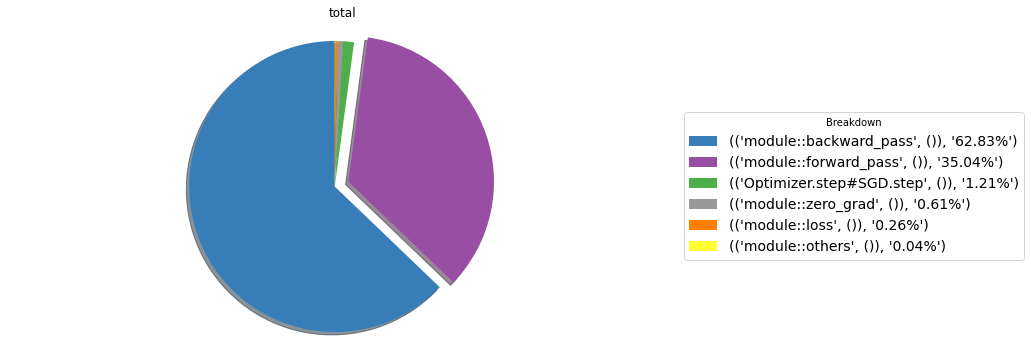

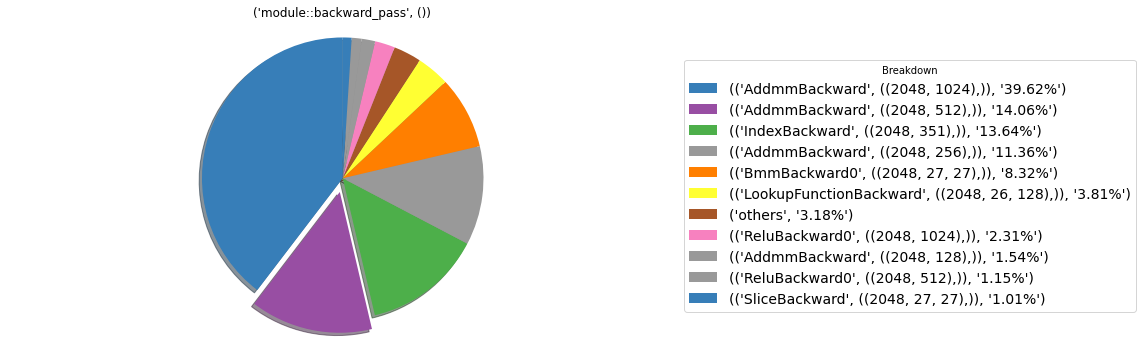

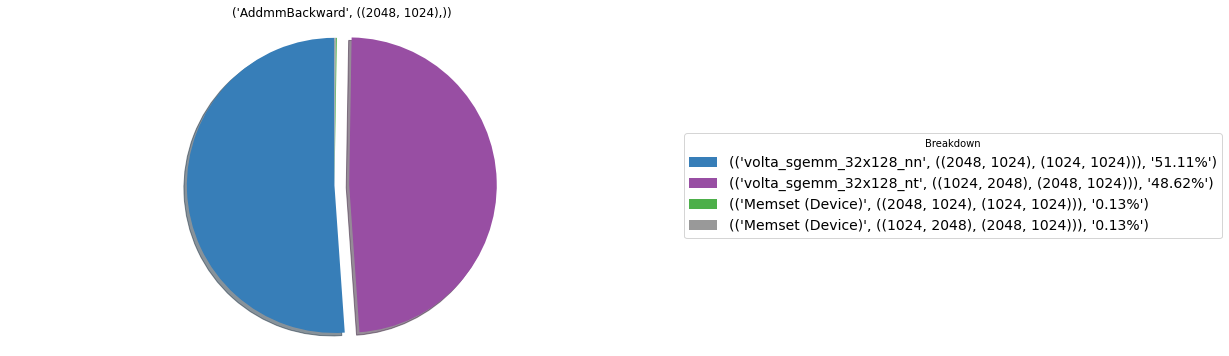

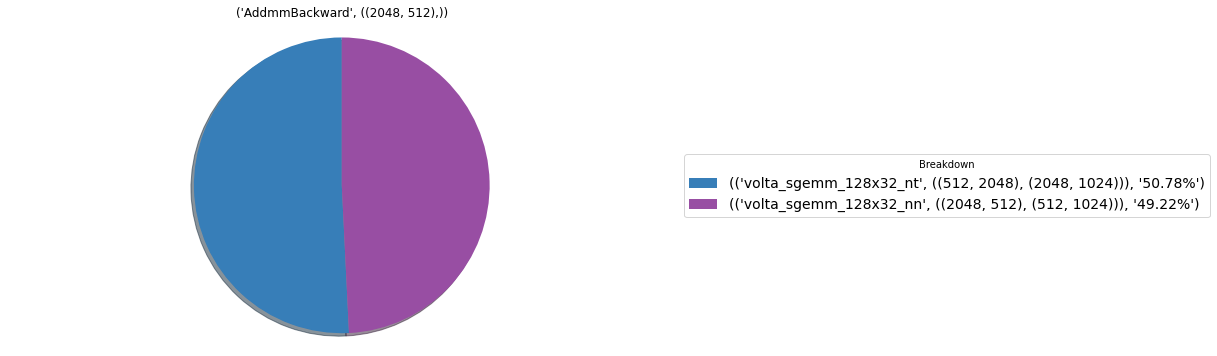

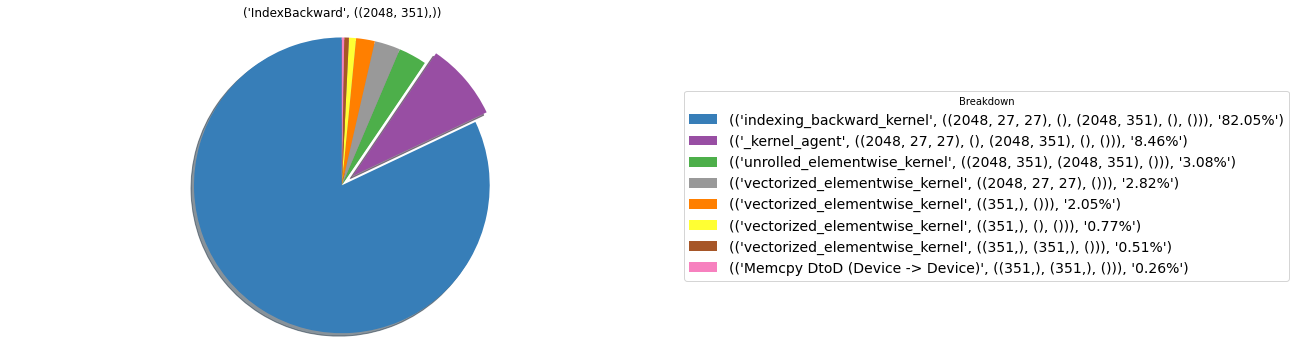

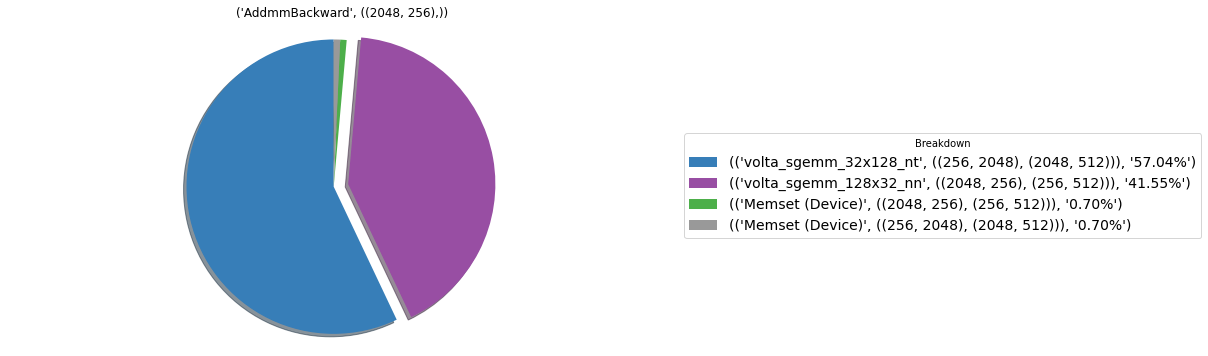

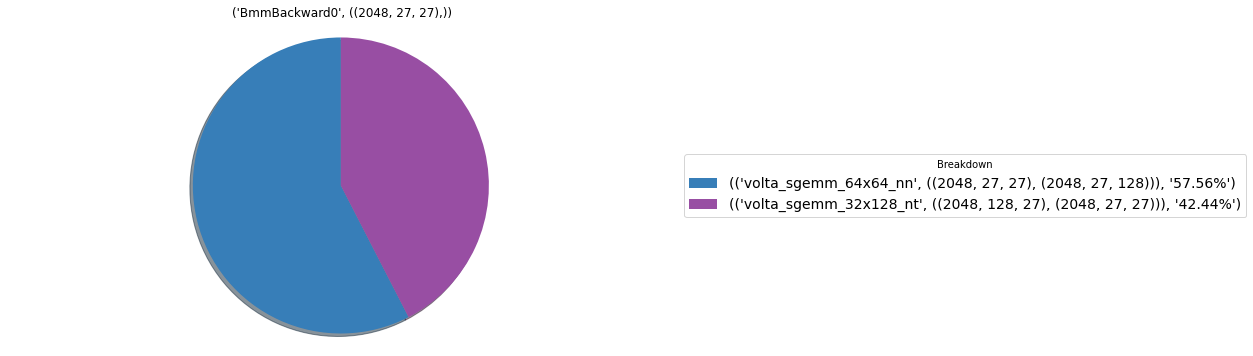

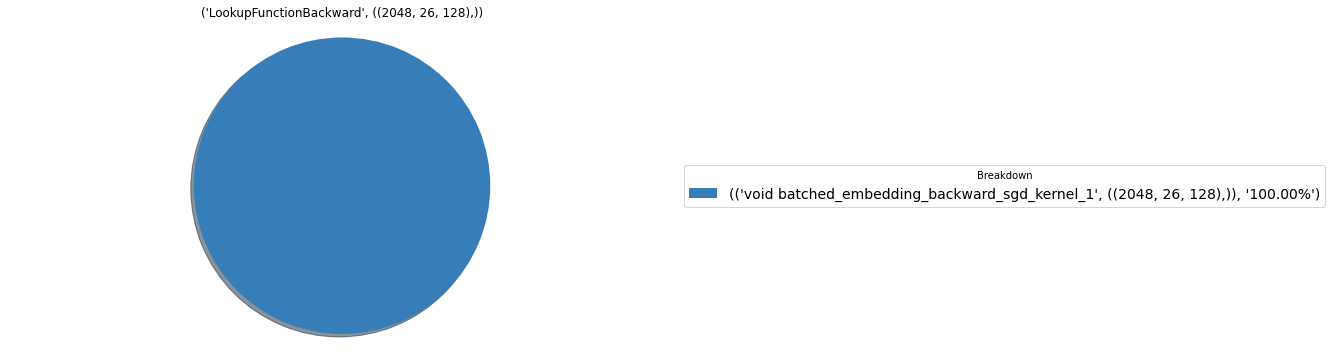

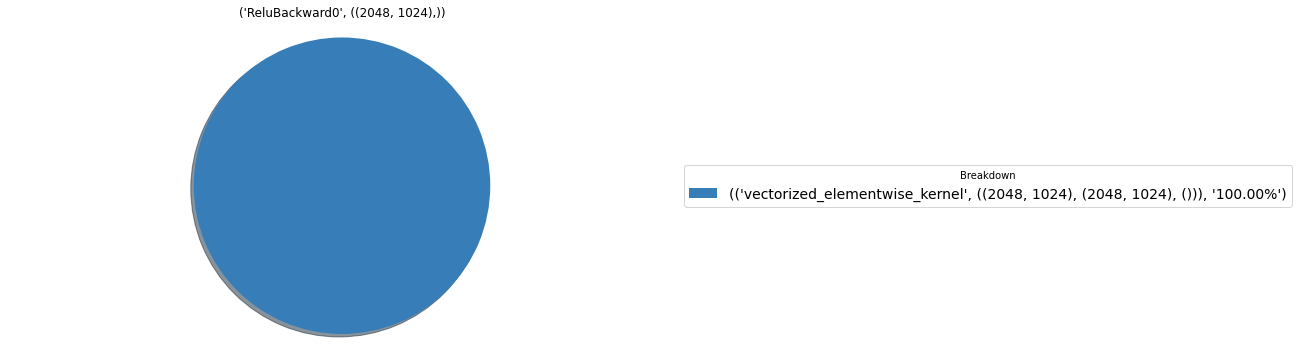

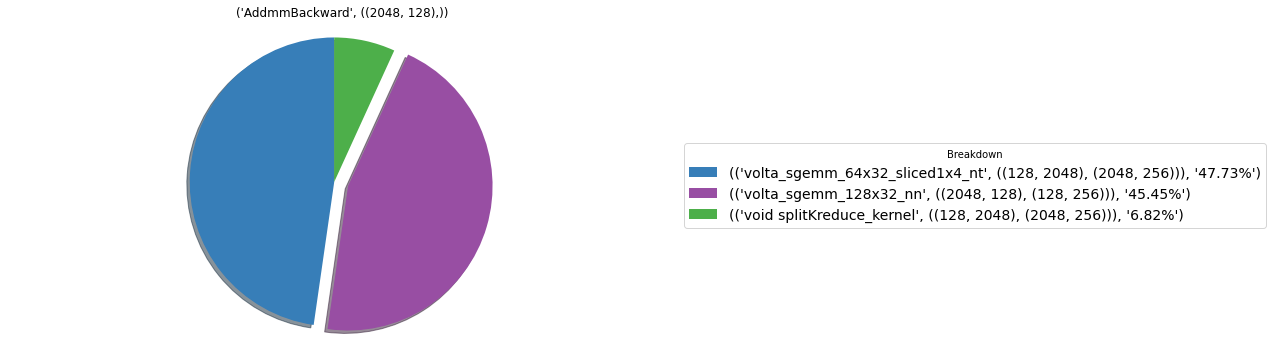

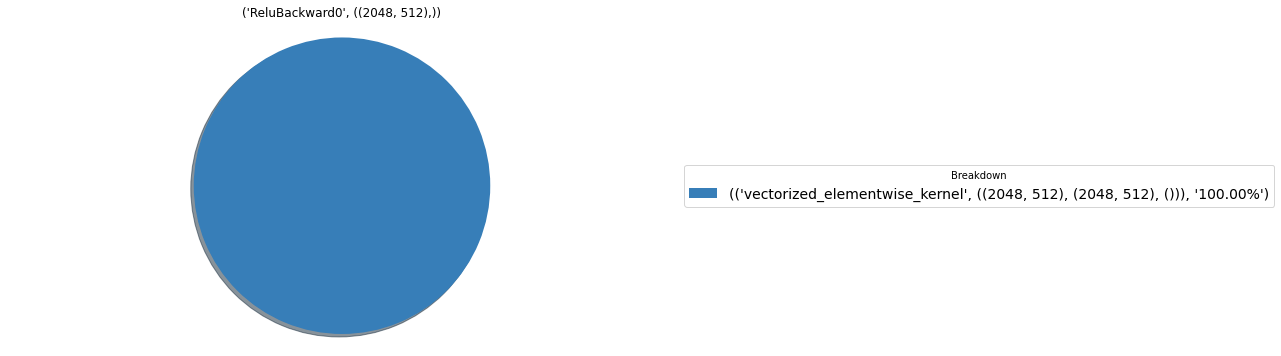

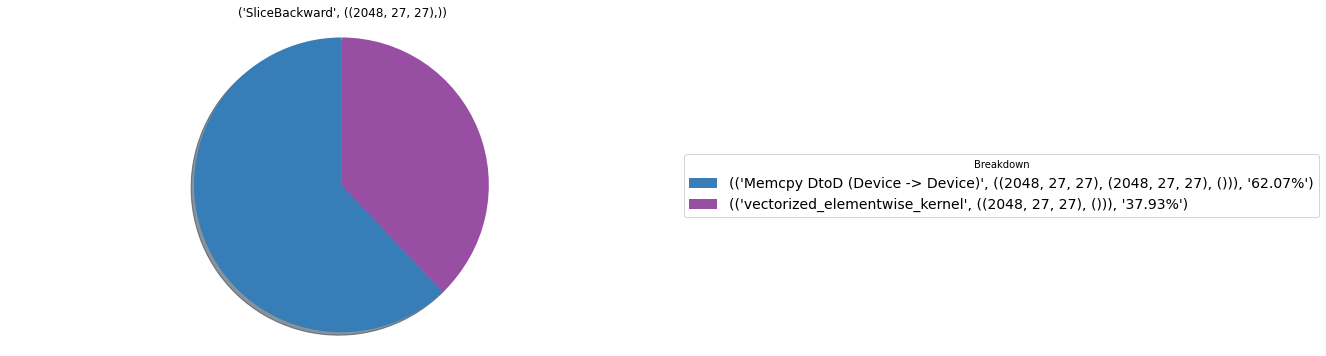

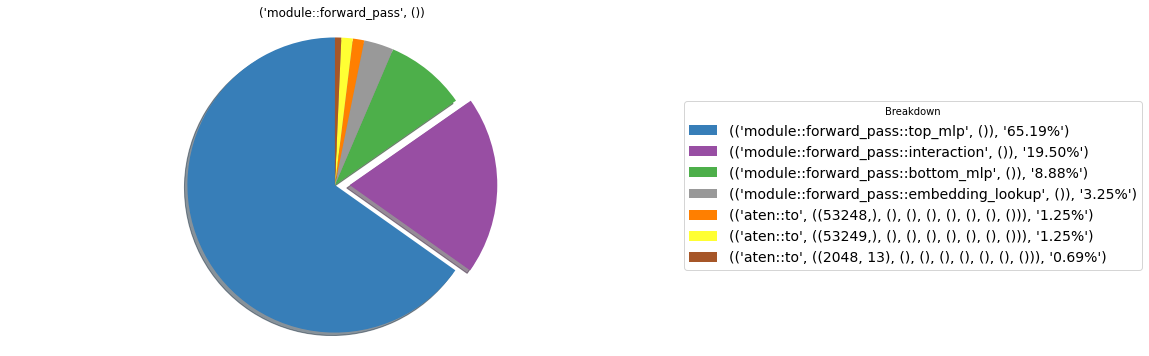

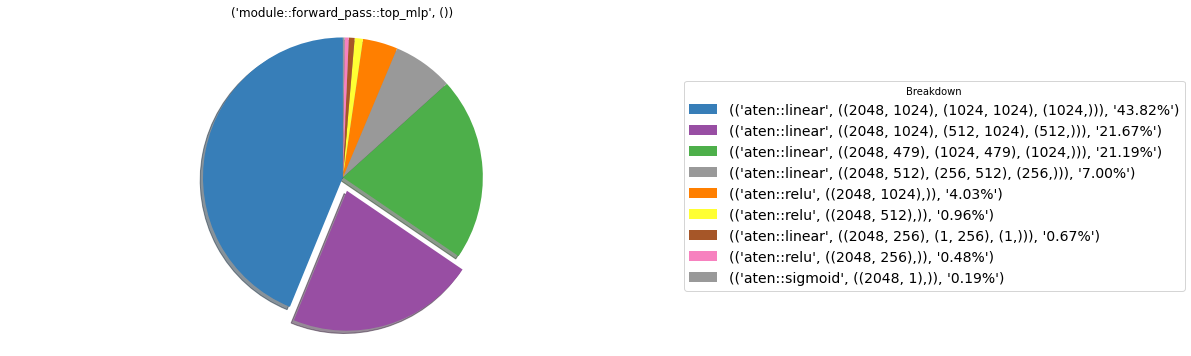

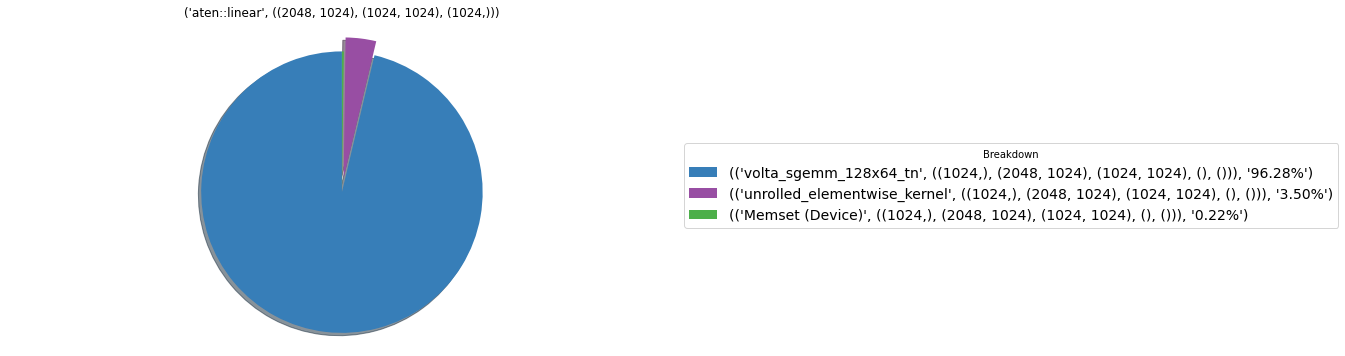

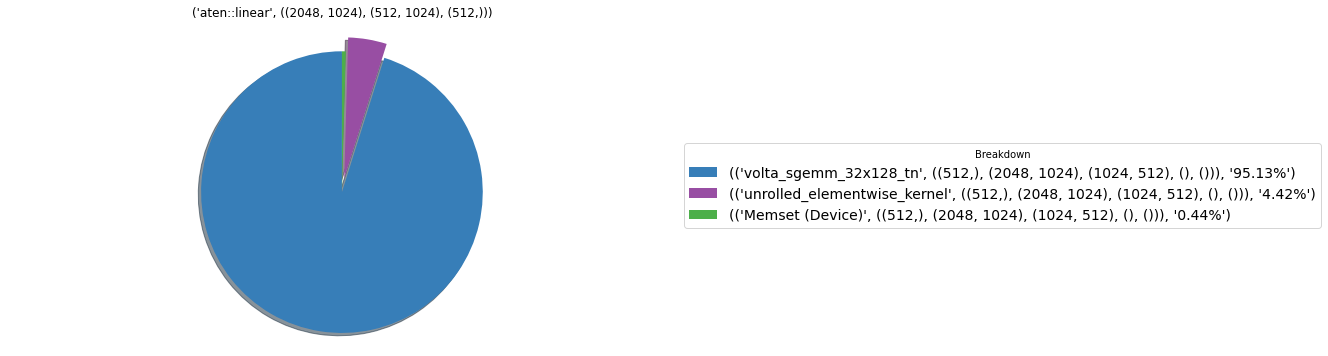

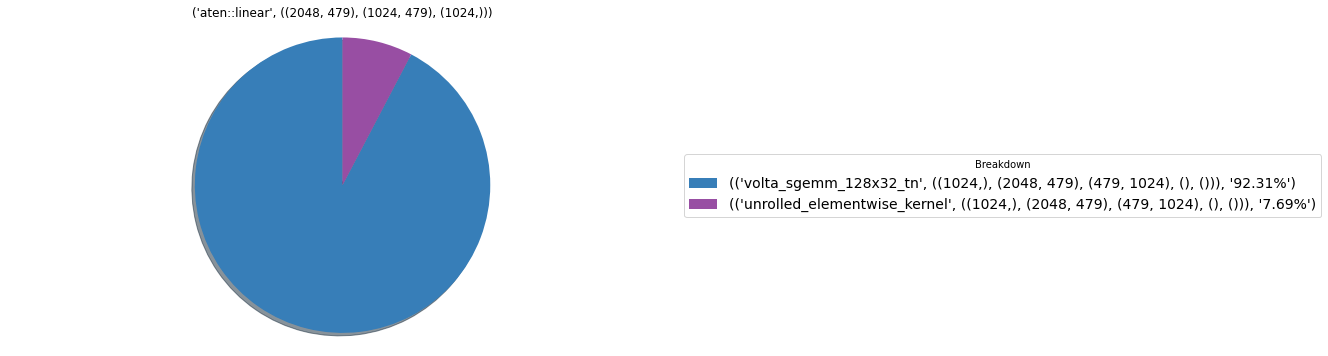

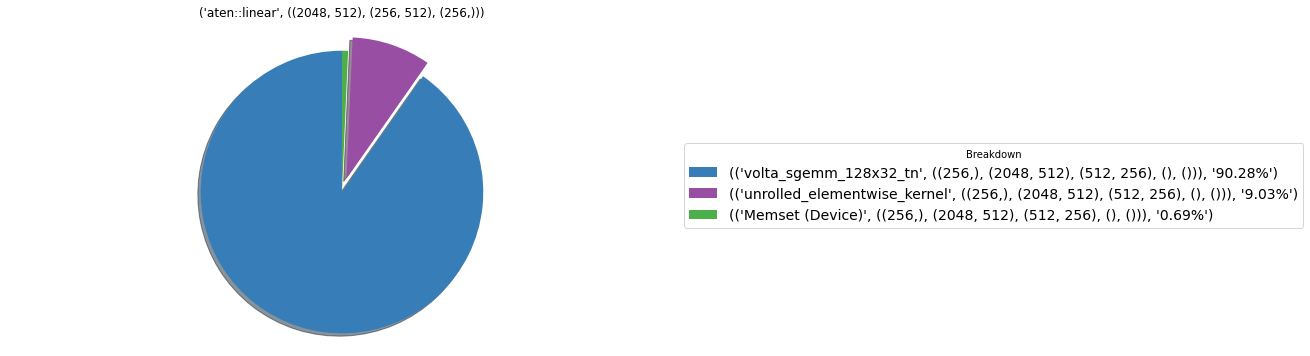

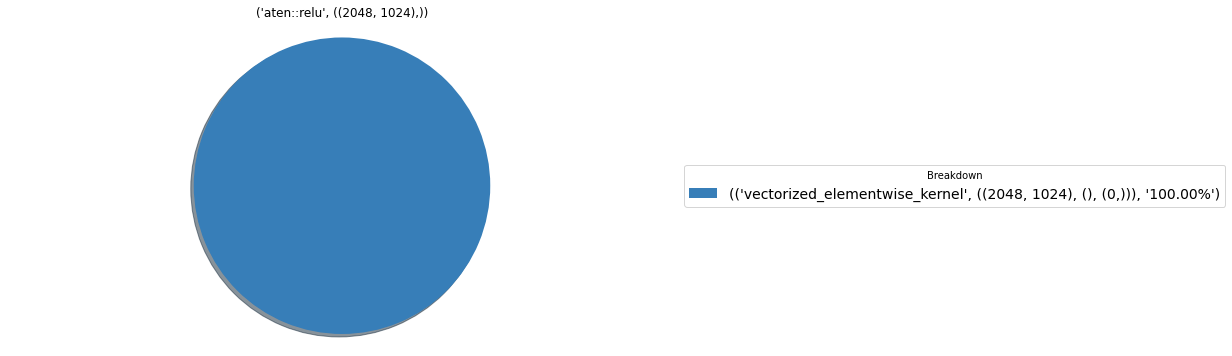

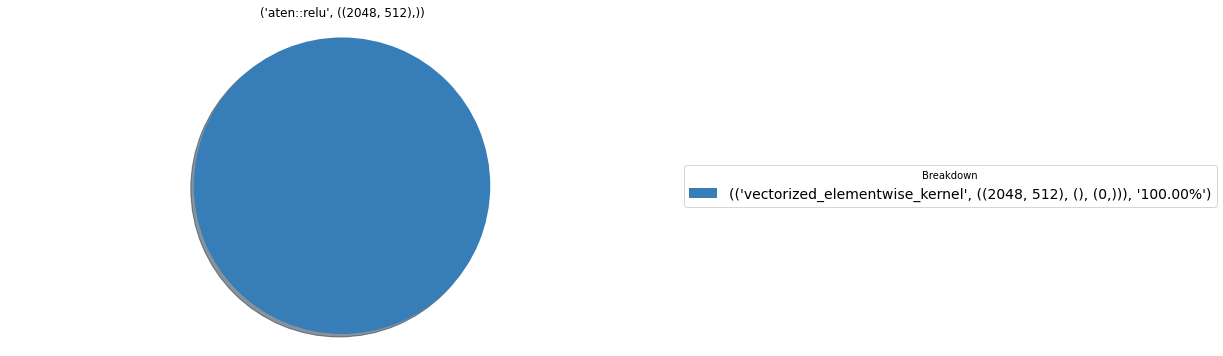

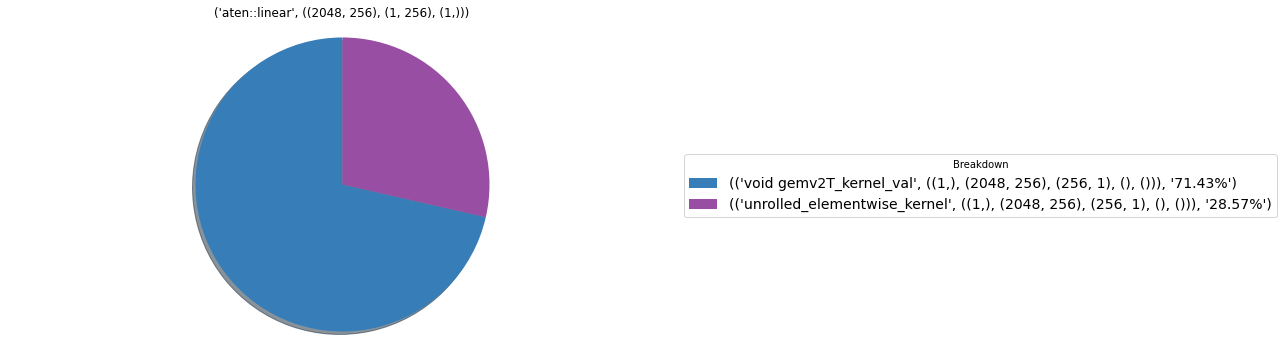

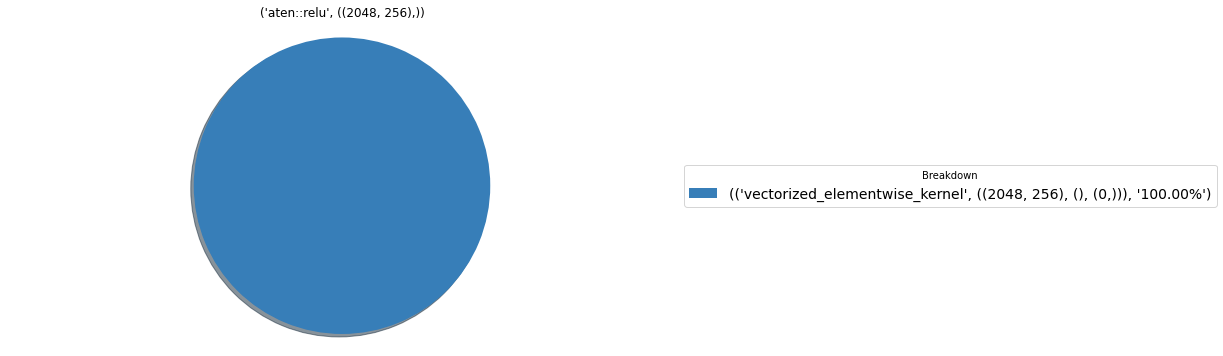

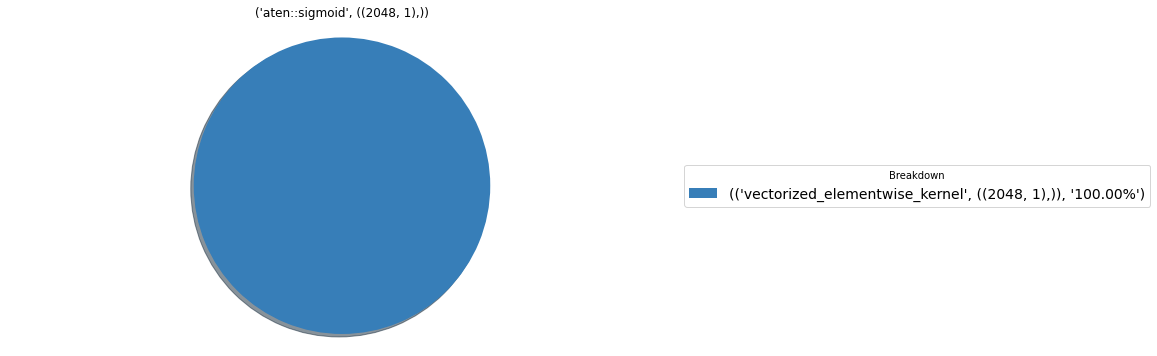

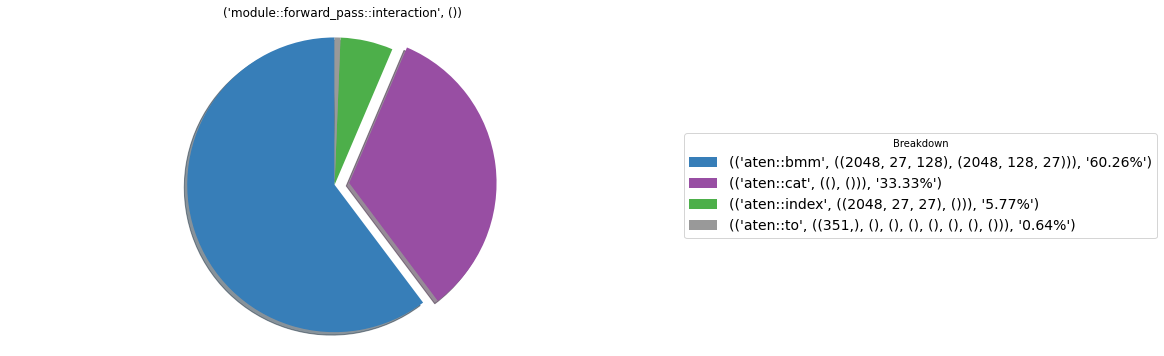

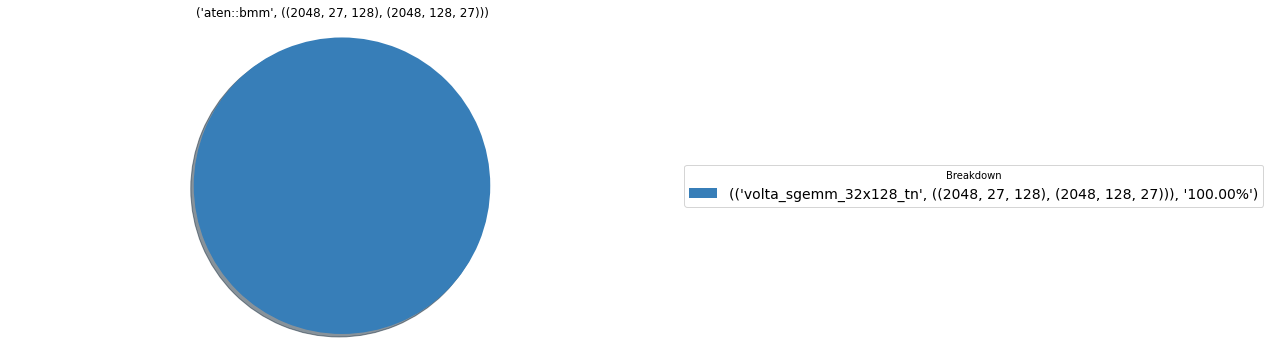

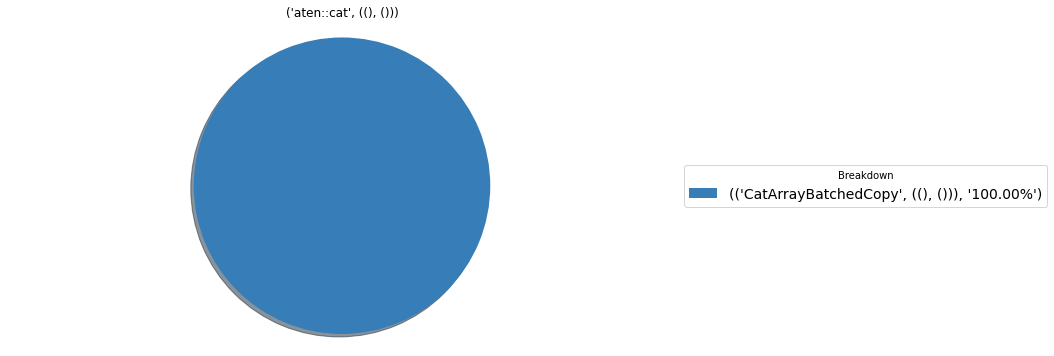

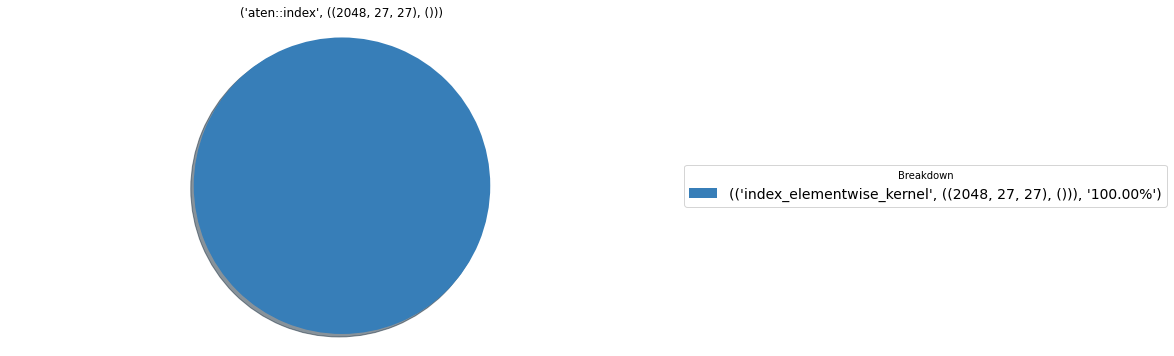

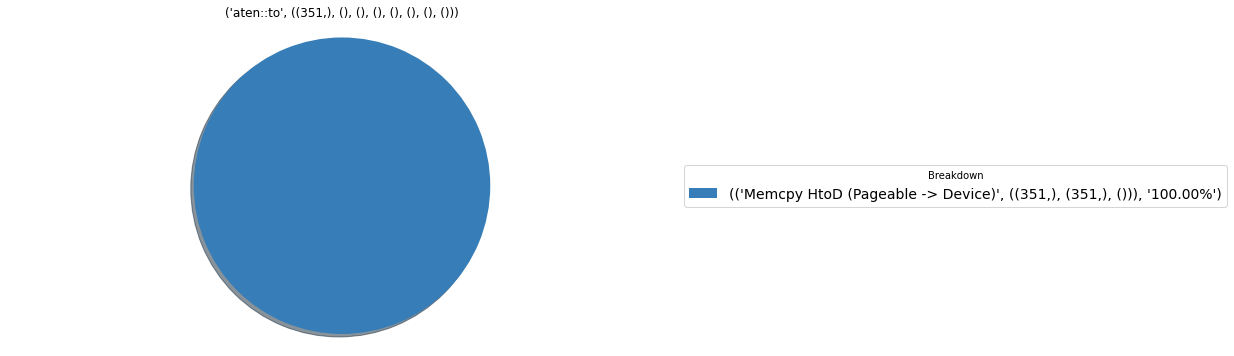

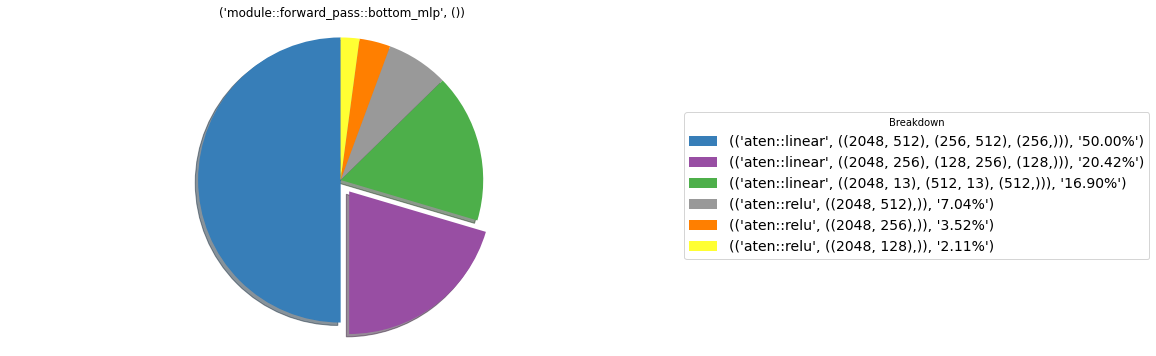

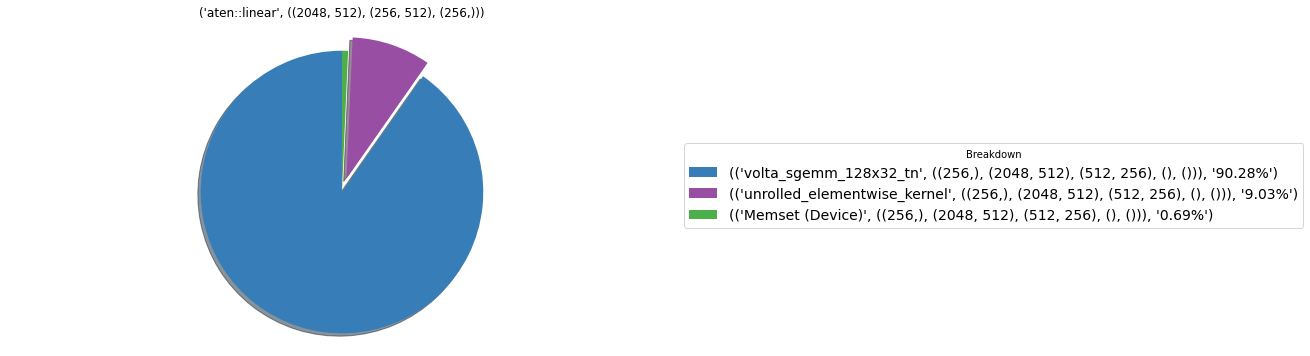

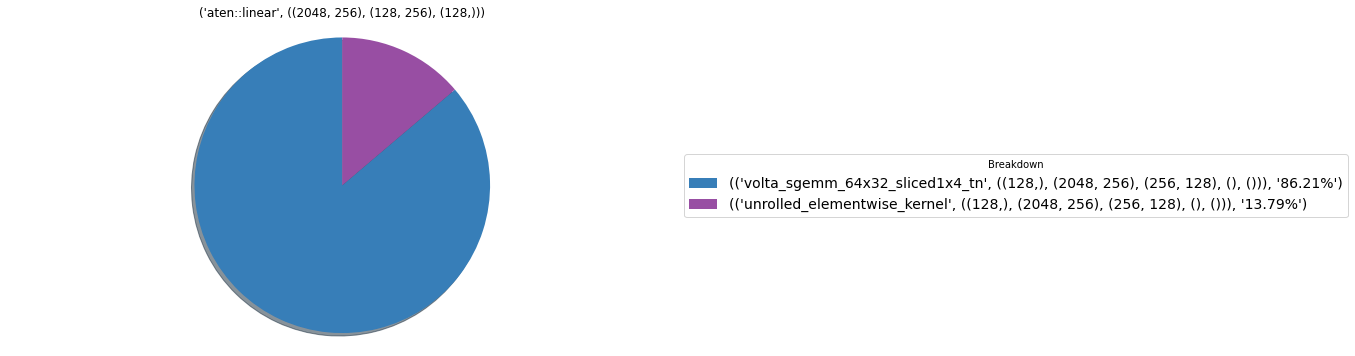

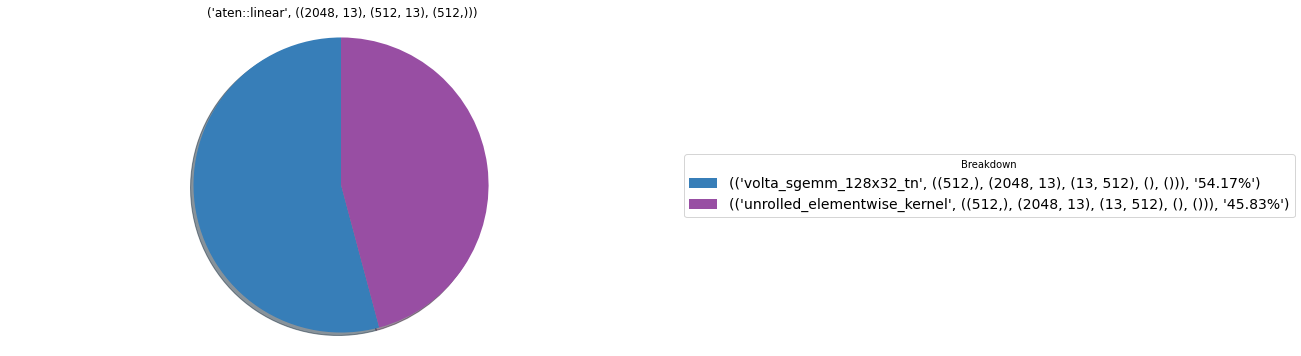

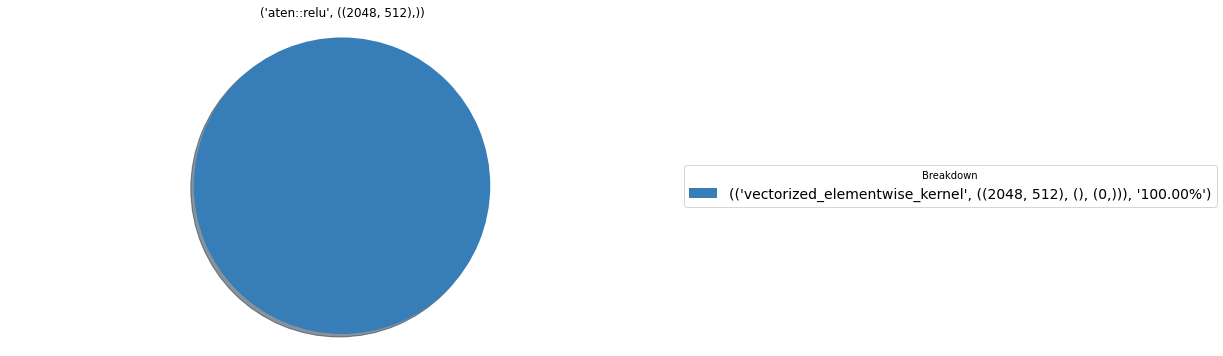

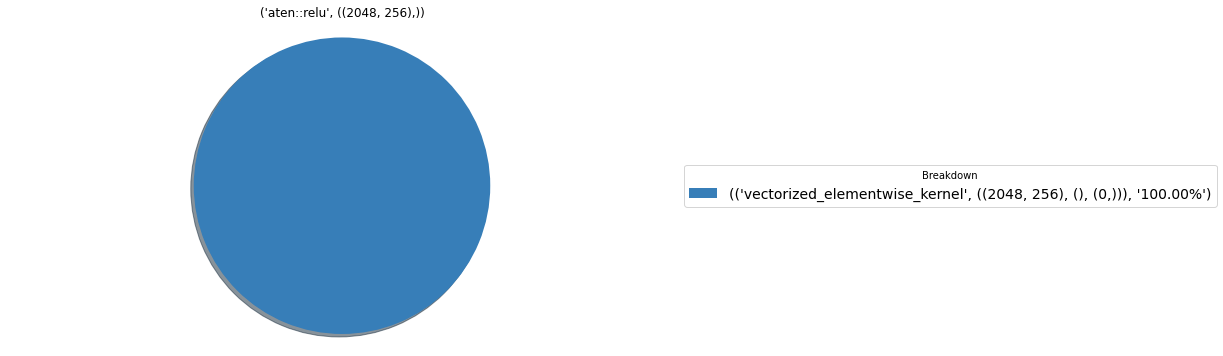

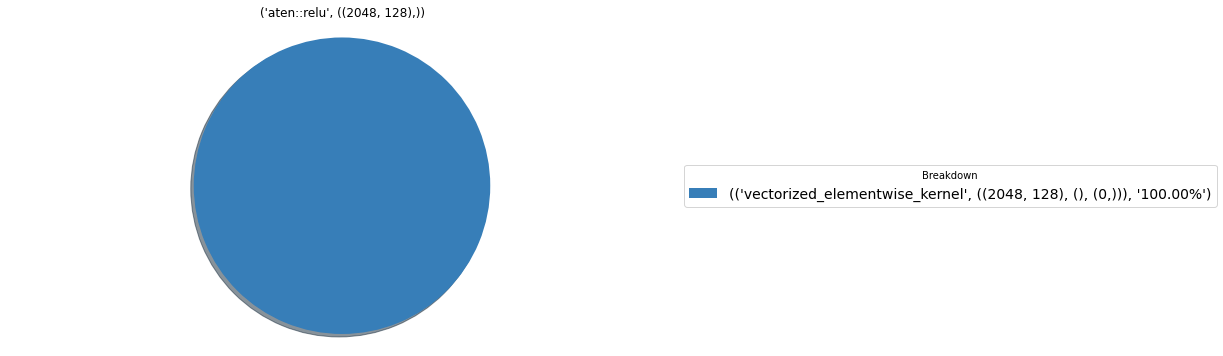

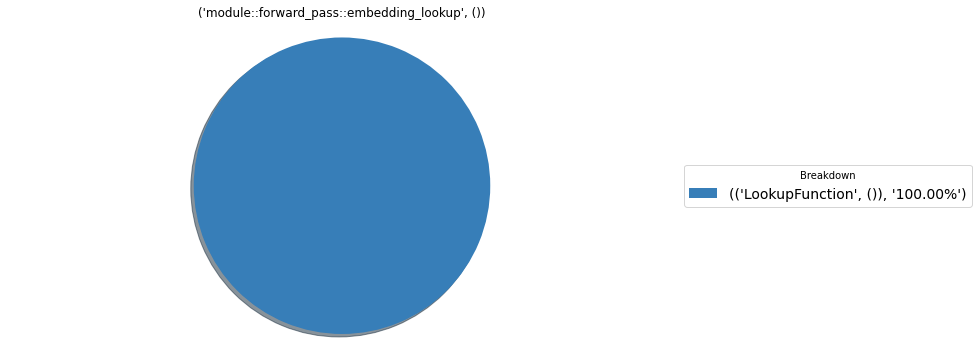

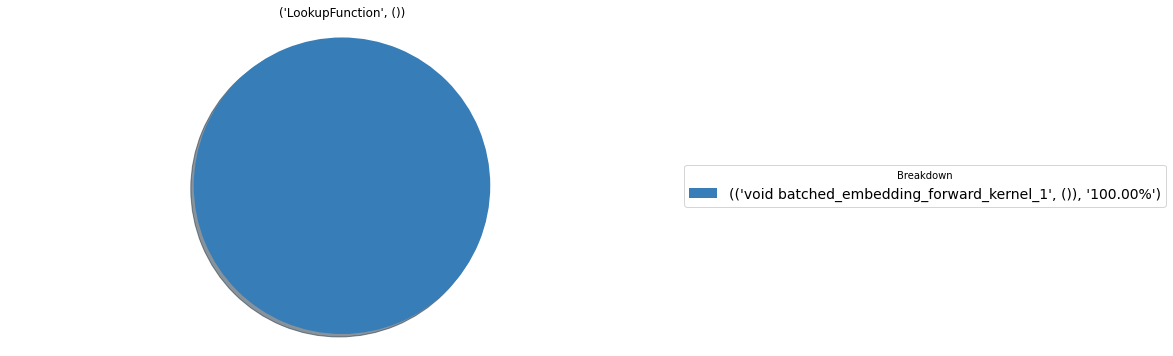

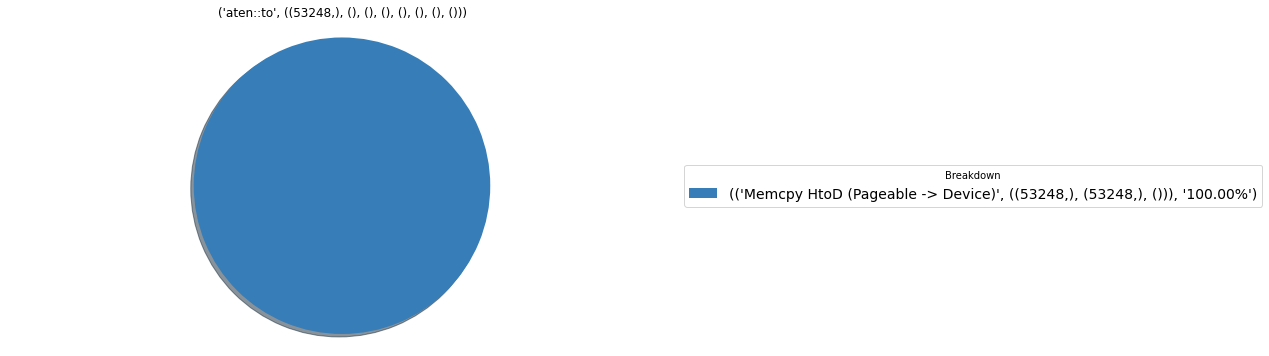

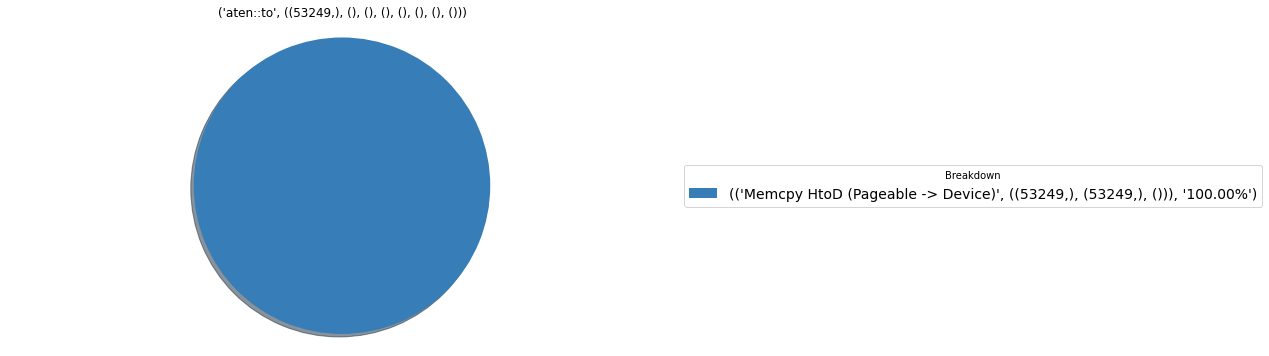

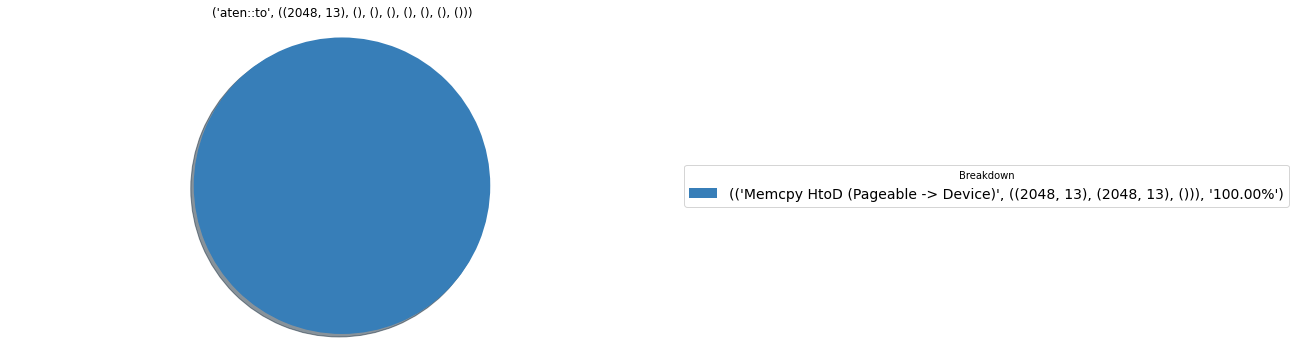

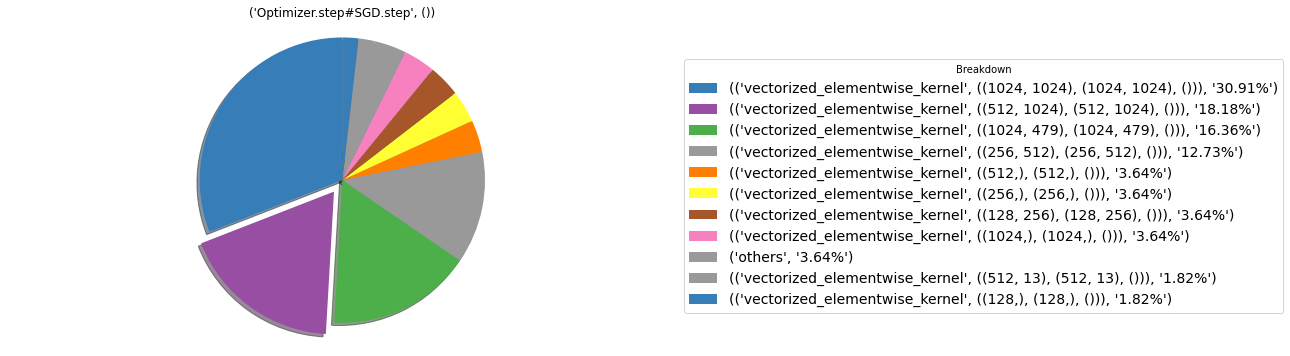

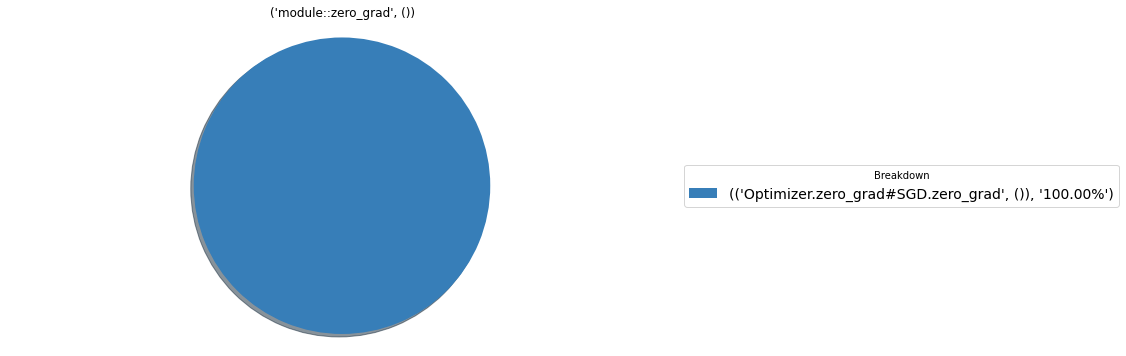

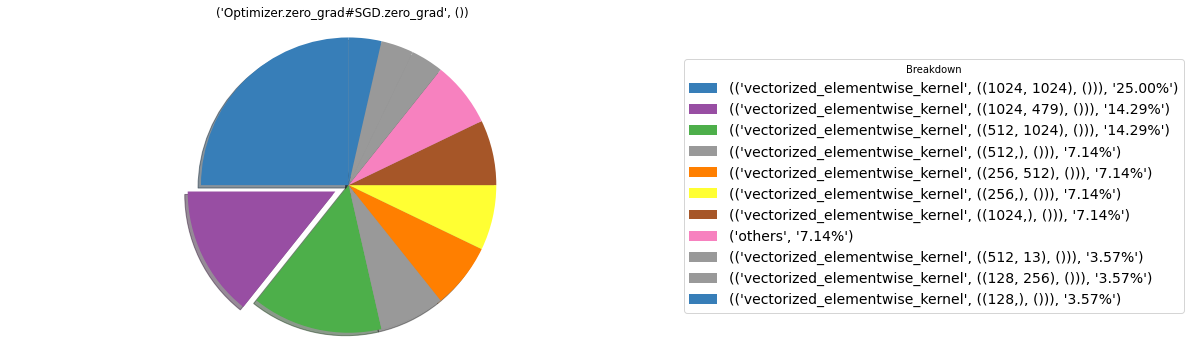

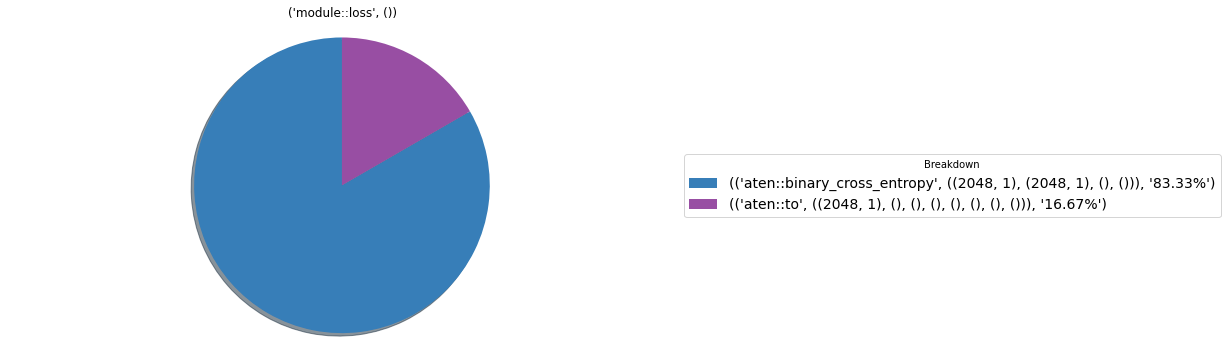

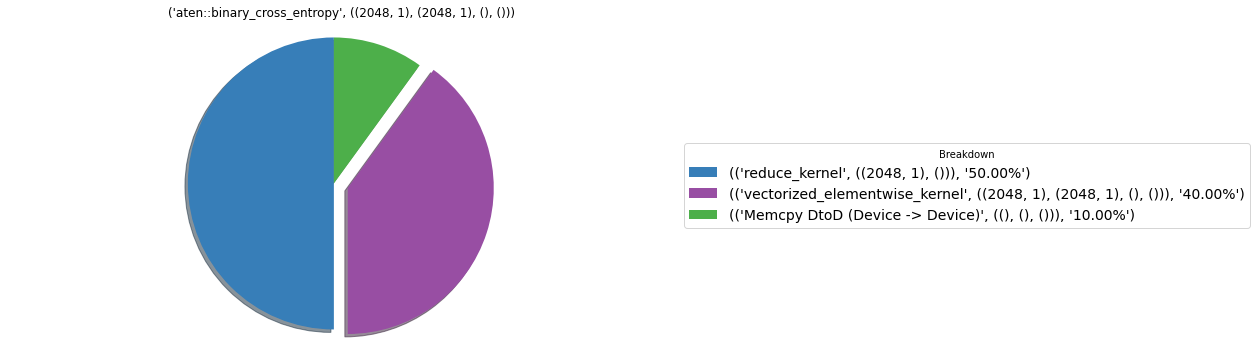

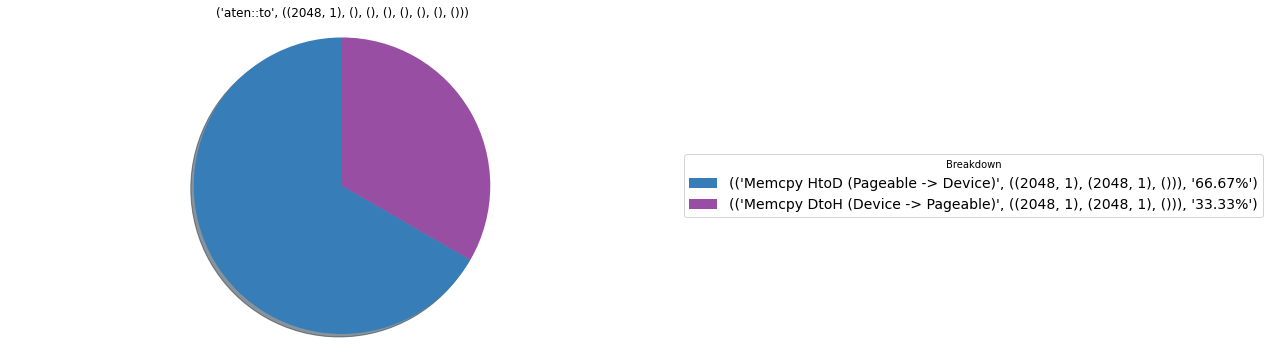

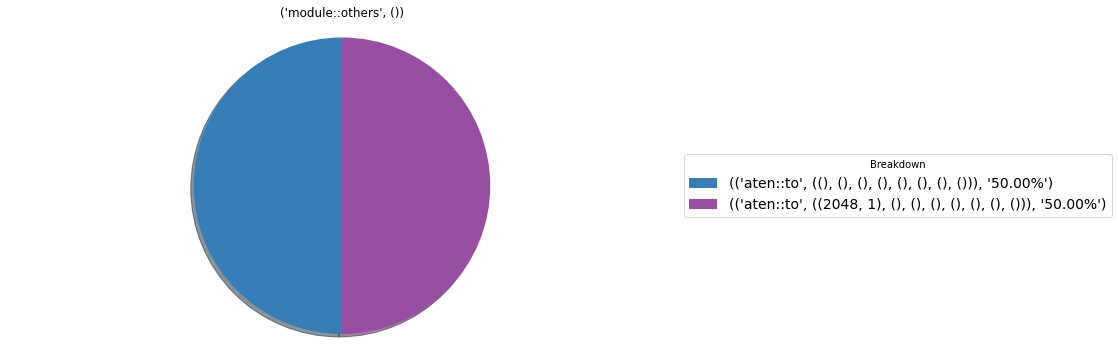

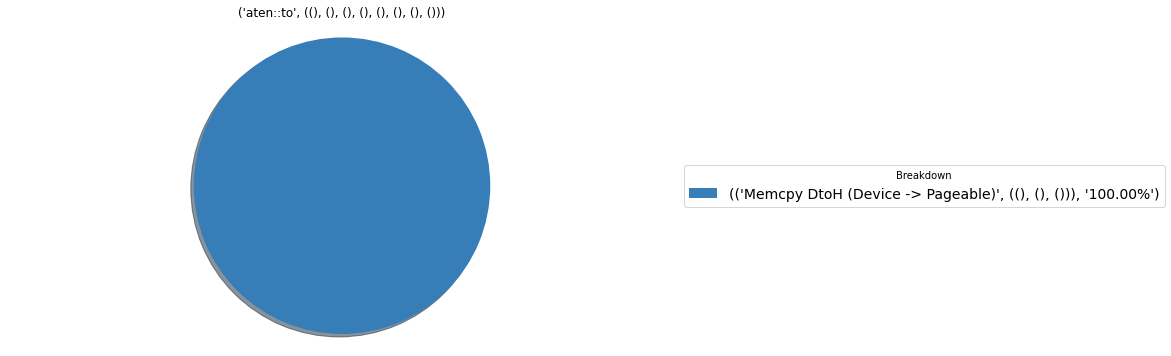

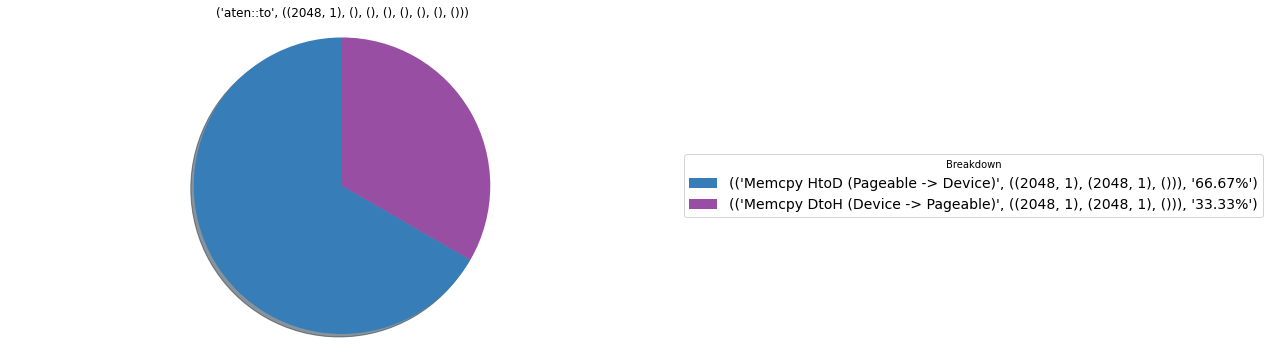

In [11]:
from matplotlib import cm
cs=cm.Set1([1, 3, 2, 25, 4, 5, 6, 7, 8, 11])

def plot_pie_chart(flatten, key="total", truncate_count=100, depth=0):
    d = flatten[key]
    
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    stats = sorted(d["subs"].items(), key=lambda x: x[1], reverse=True)
    labels = [x[0] for x in stats]
    runtime = [x[1] for x in stats]
    explode = np.zeros(len(runtime))
    if len(explode) > 2:
        explode[1] = 0.1

    fig1, ax1 = plt.subplots(figsize=(12, 6))
    wedges, texts = ax1.pie(runtime, explode=explode, shadow=True, startangle=90, colors=cs)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.set_title(key)
    
    ax1.legend(wedges, zip(labels, ["{:.2f}%".format(r / d["runtime"] * 100) for r in runtime]),
          title="Breakdown",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          fontsize=14)
    
    for label in labels:
        if label in flatten:
            plot_pie_chart(flatten, key=label, truncate_count=truncate_count, depth=depth+1)

    if depth == 0:
        plt.show()

for stream, v in flatten.items():
    print("########################")
    print("STREAM: {}".format(stream))
    print("########################")
    plot_pie_chart(v, truncate_count=truncate_count)

########################
STREAM: 7
########################


/home/m092926/.conda/envs/zhongyi/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/m092926/.conda/envs/zhongyi/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/m092926/.conda/envs/zhongyi/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


[4, 7, 1, 1, 1, 1, 1, 6, 1, 4, 1, 2, 1, 1, 1, 1, 1]
[3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1]


/home/m092926/.conda/envs/zhongyi/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:584: UserWarning: The handle <BarContainer object of 1 artists> has a label of '_kernel_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


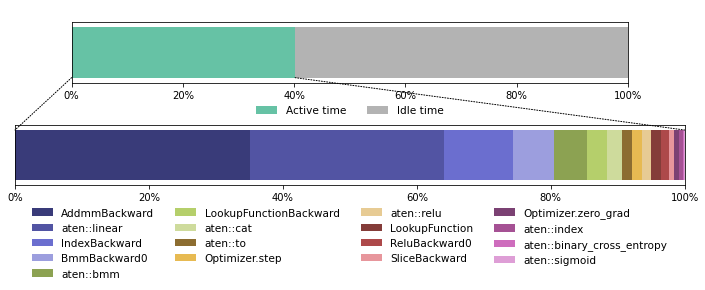

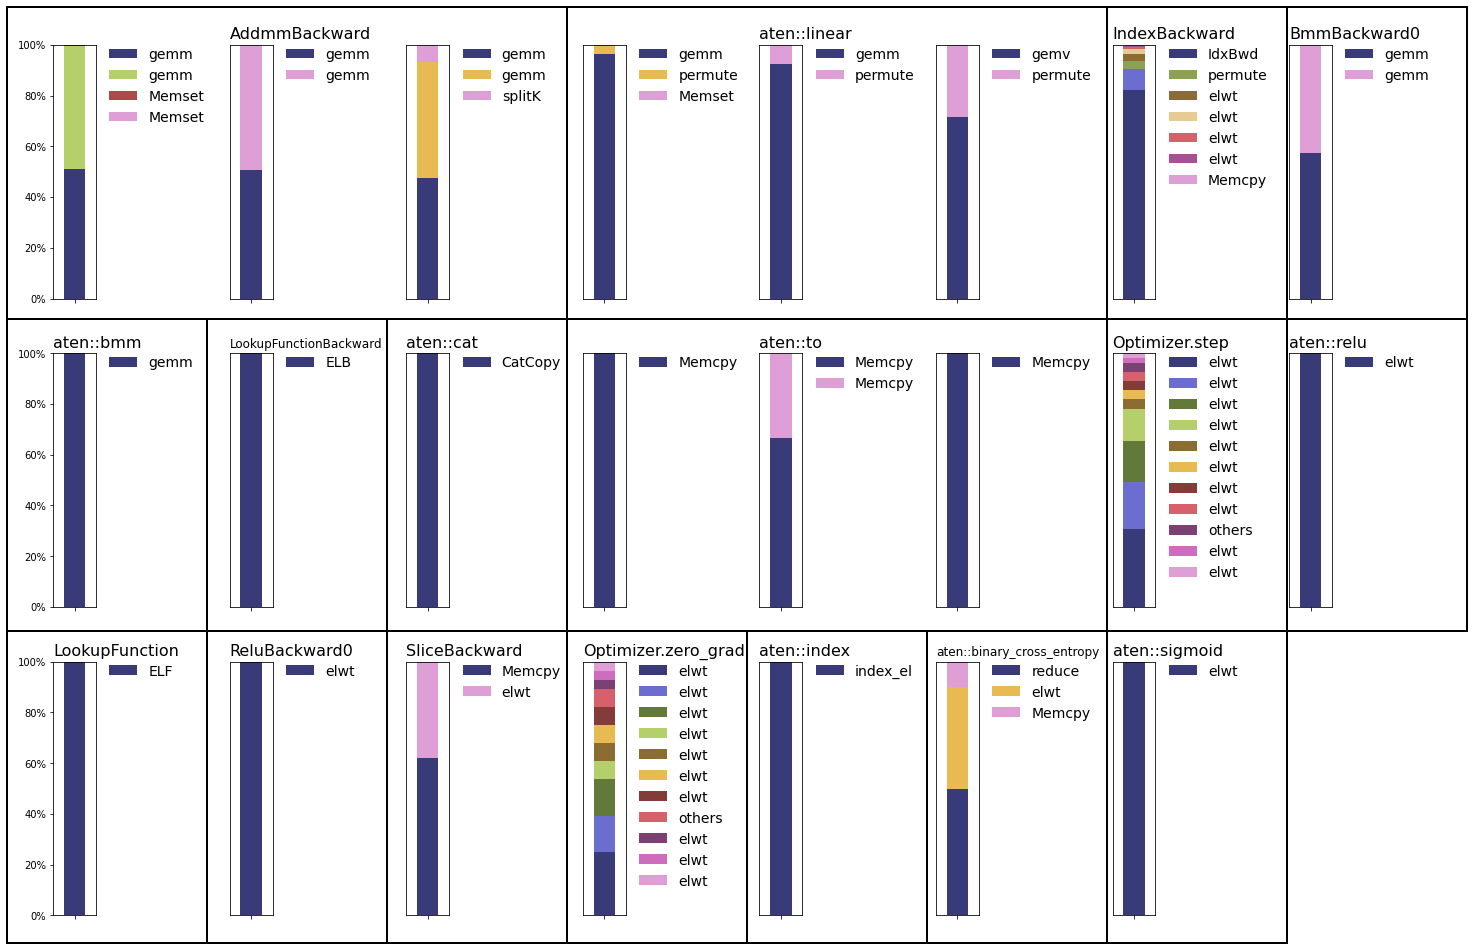

In [245]:
def kernel_name_to_legend(name):
    if 'gemm' in name:
        return 'gemm'
    if 'gemv' in name:
        return 'gemv'
    if 'Memset' in name:
        return 'Memset'
    if 'Memcpy' in name:
        return 'Memcpy'
    if 'vectorized_elementwise' in name:
        return 'elwt'
    if 'unrolled_elementwise' in name:
        return 'permute'
    if 'embedding_forward' in name:
        return 'ELF'
    if 'embedding_backward' in name:
        return 'ELB'
    if 'splitK' in name:
        return 'splitK'
    if 'reduce_kernel' in name:
        return 'reduce'
    if 'CatArray' in name:
        return 'CatCopy'
    if 'indexing' in name:
        return 'IdxBwd'
    return name[:8]

def plot_bar_chart(flatten, key="total", truncate_count=100, depth=0):
    per_op = {}
    total = 0.0
    for k, v in flatten.items():
        if k == 'total' or 'module' in k[0]:
            continue
        k0 = k[0] if '#' not in k[0] else k[0].split('#')[0]
        if k0 not in per_op.keys():
            per_op[k0] = 0.0
        per_op[k0] += v['runtime']
        total += v['runtime']
        
    tmp = sorted(per_op.items(), key=lambda x: x[1], reverse=True)
    op = [x[0] for x in tmp]
    p = [x[1] / total for x in tmp]
    df0 = pd.DataFrame({
        'Active time': [flatten['total']['runtime'] / device_runtime],
        'Idle time': [1 - flatten['total']['runtime'] / device_runtime]
    })
    df = pd.DataFrame([p], columns=op)
    
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 3))
    axes[0] = plt.subplot2grid(shape=(2, 12), loc=(0, 1), colspan=10) # Uneven sizes of subplots
    axes[1] = plt.subplot2grid(shape=(2, 12), loc=(1, 0), colspan=12)

    ax0 = df0.plot(stacked=True, title=" ", kind='barh', width=0.05, ax=axes[0], cmap='Set2')
    vals = ax0.get_xticks()
    ax0.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
    ax0.set_xlim((0.0, 1.0))
    ax0.set_yticks([])
    ax0.set_yticklabels([])
    ax0.set_ylim((-0.03, 0.03))
    ax0.legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.7), frameon=False, fontsize=10.5)
    
    ax1 = df.plot(stacked=True, kind='barh', width=0.05, ax=axes[1], cmap='tab20b') # https://matplotlib.org/stable/tutorials/colors/colormaps.html
    vals = ax1.get_xticks()
    ax1.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
    ax1.set_xlim((0.0, 1.0))
    ax1.set_yticks([])
    ax1.set_yticklabels([])
    ax1.set_ylim((-0.03, 0.03))
    ax1.legend(loc="lower center", ncol=4, bbox_to_anchor=(0.5, -1.7), frameon=False, fontsize=10.5)
    
    # Space between subplots
    plt.subplots_adjust(hspace=0.7)
    
    # Lines across subplots
    con1 = ConnectionPatch(xyA=(0,-0.025), xyB=(0,0.025), coordsA="data", coordsB="data", axesA=ax0, axesB=ax1, linestyle='dotted')
    con2 = ConnectionPatch(xyA=(flatten['total']['runtime'] / device_runtime,-0.025), xyB=(1,0.025), coordsA="data", coordsB="data", axesA=ax0, axesB=ax1, linestyle='dotted')
    ax1.add_artist(con1)
    ax1.add_artist(con2)

    plt.tight_layout()
    plt.rcParams['figure.figsize'] = [12, 3]
    plt.savefig('active_time_breakdown.pdf', bbox_inches='tight')
    
    t = {}
    for k, v in flatten.items():
        if k == 'total' or 'module' in k[0]:
            continue
        k0 = k[0] if '#' not in k[0] else k[0].split('#')[0]
        if k0 not in t.keys(): # Per Op
            t[k0] = []
        a = {}
        total = 0.0
        for kk, vv in v['subs'].items():
            a[kk] = vv
            total += vv
        a = {x: y / total for x, y in a.items()}
        t[k0].append(a)
    so = sorted(t.items(), key=lambda x: per_op[x if isinstance(x, str) else x[0]], reverse=True)
    pprint([len(s[1]) for s in so])
    so = [list(x) for x in so]

    for s in so:
        keys = set()
        to_be_deleted = []
        # Find duplicate kernel combinations
        for idx, b in enumerate(s[1]):
            k = []
            for x in b.keys():
                if 'volta_sgemm' in x[0]:
                    xx = 'volta_sgemm'
                elif 'maxwell_sgemm' in x[0]:
                    xx = 'maxwell_sgemm'
                elif isinstance(x, str):
                    xx = x
                else:
                    xx = x[0]
                k.append(xx)
            k = tuple(sorted(k))
            if k in keys:
                to_be_deleted.append(idx)
            else:
                keys.add(k)
        # Delete duplicate kernel combinations
        for idx in sorted(to_be_deleted, reverse=True):
            del s[1][idx]
    pprint([len(s[1]) for s in so])
#     pprint(so)

    nrows, ncols = 3, 8
    fig, axes = plt.subplots(nrows=3, ncols=8, figsize=(20, 13))
    xx, yy = 0, 0
    rects, texts = [], []
    for s in so:
        num_variants = len(s[1])
        for idx, b in enumerate(s[1]):
            ax = plt.subplot(nrows, ncols, 1+xx+idx+yy*ncols)
            p = sorted(b.items(), key=lambda x: x[1], reverse=True)
            kernel_name = [kernel_name_to_legend(x[0] if isinstance(x[0], str) else x[0][0]) for x in p]
            perc = [x[1] for x in p]
            df = pd.DataFrame([perc], columns=kernel_name)
            _ = df.plot(stacked=True, kind='bar', ax=ax, cmap='tab20b')
            ax.get_legend().remove()
            if xx+idx == 0:
                ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
                ax.set_yticklabels(['{:,.0%}'.format(x) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
            else:
                ax.set_yticks([])
                ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_ylim((0.0, 1.0))
            ax.legend(bbox_to_anchor=(1.02, 1.04), loc='upper left', frameon=False, fontsize=14)
            if idx == (len(s[1]) - 1) / 2:
                ax.set_title(s[0], loc='left', fontsize=(16 if len(s[0]) < 20 else 12))
            
        # Borders
        llc_x = 1.0 / ncols * (xx) + (0.014 if xx != 0 else 0)
        llc_y = 1.0 / nrows * (nrows-yy-1) + 0.01
        rx = 1.0 / ncols * (num_variants) + (0.014 if xx == 0 else 0)
        ry = 1.0 / nrows
        rects.append(plt.Rectangle(
            (llc_x, llc_y), rx, ry, fill=False, color="k", lw=2, zorder=1000, transform=fig.transFigure, figure=fig
        ))

        # Subplot position
        xx += num_variants
        if xx >= ncols:
            xx = 0
            yy += 1

    # Hardcoded for now
    axes[2,7].set_axis_off()
    
    fig.patches.extend(rects)
    plt.tight_layout()
    plt.rcParams['figure.figsize'] = [20, 13]
    plt.savefig('dominating_op_breakdown.pdf', bbox_inches='tight')

for stream, v in flatten.items():
    print("########################")
    print("STREAM: {}".format(stream))
    print("########################")
    plot_bar_chart(v, truncate_count=truncate_count)

In [235]:
pprint(flatten)

{7: {'total': {'runtime': 45776.0,
               'subs': {('Optimizer.step#SGD.step', ()): 552.0,
                        ('module::backward_pass', ()): 28762.0,
                        ('module::forward_pass', ()): 16042.0,
                        ('module::loss', ()): 120.0,
                        ('module::others', ()): 20.0,
                        ('module::zero_grad', ()): 280.0}},
     ('AddmmBackward', ((2048, 128),)): {'runtime': 44.0,
                                         'subs': {('void splitKreduce_kernel', ((128, 2048), (2048, 256))): 3.0,
                                                  ('volta_sgemm_128x32_nn', ((2048, 128), (128, 256))): 20.0,
                                                  ('volta_sgemm_64x32_sliced1x4_nt', ((128, 2048), (2048, 256))): 21.0}},
     ('AddmmBackward', ((2048, 256),)): {'runtime': 142.0,
                                         'subs': {('Memset (Device)', ((256, 2048), (2048, 512))): 1.0,
                                         

In [11]:
def histogram(df, perc=True, is_abs=False, bins=[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 1.5, 2.0, 3.0, 4.0]):
    count = len(df)
    ret = {}
    if is_abs:
        tmp_bins = []
        for i in range(0, len(bins) - 1):
            tmp_bins.append(-bins[len(bins) - 1 - i])
        for b in bins:
            tmp_bins.append(b)
        bins = tmp_bins
    for idx, b in enumerate(bins):
        if idx == 0:
            continue
        ret[(bins[idx-1], bins[idx])] = 0
    for x in df:
        for idx, b in enumerate(bins):
            if idx == 0:
                continue
            if x >= bins[idx-1] and x < bins[idx]:
                ret[(bins[idx-1], bins[idx])] += 1
                break
    for b, c in sorted(ret.items(), key=lambda x: x[0]):
        if perc:
            print("{:.0f}% - {:.0f}%: {:.2f}%".format(b[0] * 100, b[1] * 100, c / count * 100))
        else:
            print("{:.2f} - {:.2f}: {:.2f}%".format(b[0], b[1], c / count * 100))
    return ret

In [12]:
# Type 1 overhead: between two op calls
# Type 2 overhead: before the first device call, op-specific
# Type 3 overhead: after the last device call, op-specific
# Type 4 overhead: kernel launches themselves, kernel-launch-type-specific
# Type 5 overhead: sum of gaps between kernel launches, op-specific
overheads = {'independent': {}}
overheads['independent']['t1'] = [] # Independent from names
overheads['independent']['t4'] = {} # Independent from names

for i, op in enumerate(ops):
    name = op.name()
    if name not in overheads.keys():
        overheads[name] = {}

    if 't2' not in overheads[name].keys():
        overheads[name]['t2'] = []
    if 't3' not in overheads[name].keys():
        overheads[name]['t3'] = []
    if 't5' not in overheads[name].keys():
        overheads[name]['t5'] = []

    if op.has_device_calls:
        launches = get_event_all_kernel_launches(op)
        overheads[name]['t2'].append(launches[0].start_time() - op.start_time())
        overheads[name]['t3'].append(op.end_time() - launches[-1].end_time())
        overheads[name]['t5'].append(sum([launches[i].start_time() - launches[i-1].end_time() for i in range(1, len(launches))]))
        
        # T4 is launch-type-dependent
        for x in launches:
            if x.name() not in overheads['independent']['t4']:
                overheads['independent']['t4'][x.name()] = []
            overheads['independent']['t4'][x.name()].append(x.duration())
    else:
        if op.name not in overheads[name].keys():
            overheads[name]['t5'] = []
        overheads[name]['t5'].append(op.duration())

    if i == 0:
        continue
    prev_op = ops[i-1]
    
    # Only consider adjacent ops under the SAME MODULE
    if prev_op.parent != op.parent:
        continue
        
    gap = op.start_time() - prev_op.end_time()
    if gap < 200: # Skip dataloading gaps
        overheads['independent']['t1'].append(gap) # Some pairs of ops are actually inserted by a runtime call which has been filtered from ops. TODO: fix it.

# # T1: mean ~= 21, std ~= 20
# histogram(overheads['independent']['t1'], perc=False, bins=[0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 200, 100000])
# print(np.mean(overheads['independent']['t1']), np.std(overheads['independent']['t1']))

# # T2, T3, T5
# t2 = {k: (np.mean(v['t2']), np.std(v['t2'])) for k, v in overheads.items() if k != 'independent' and len(v['t2']) > 0}
# pprint(t2)
# t3 = {k: (np.mean(v['t3']), np.std(v['t3'])) for k, v in overheads.items() if k != 'independent' and len(v['t3']) > 0}
# pprint(t3)
# t5 = {k: (np.mean(v['t5']), np.std(v['t5'])) for k, v in overheads.items() if k != 'independent' and len(v['t5']) > 0}
# pprint(t5)

# # T4
# for t, l in overheads['independent']['t4'].items():
#     print(t, np.mean(l), np.std(l))

In [13]:
pd.set_option('display.max_rows', None)
op_names = []
op_input_shapes = []
op_duration = []
for op in ops:
    if op.parent is not None and (op.parent.name().startswith("module::forward_pass") or op.parent.name().startswith("module::backward_pass")):
        op_names.append(op.name())
        op_input_shapes.append(op.input_shape())
        op_duration.append(op.duration())
forward_backward_ops = pd.DataFrame(list(zip(op_names, op_input_shapes, op_duration)), columns=["names", "shapes", "duration on host (us)"])
forward_backward_ops

names  \
0                        aten::empty   
1                           aten::to   
2                           aten::to   
3                           aten::to   
4                        aten::zeros   
5                        aten::empty   
6                       aten::linear   
7                         aten::relu   
8                       aten::linear   
9                         aten::relu   
10                      aten::linear   
11                        aten::relu   
12                       aten::zeros   
13                       aten::empty   
14                          aten::to   
15                          aten::to   
16                    LookupFunction   
17                       aten::zeros   
18                       aten::empty   
19                        aten::view   
20                         aten::cat   
21                   aten::transpose   
22                         aten::bmm   
23                       aten::empty   
24                          aten::to   
25                     aten::detach_   
26                       aten::empty   
27                          aten::to   
28                     aten::detach_   
29                       aten::slice   
30                          aten::to   
31                          aten::to   
32                       aten::index   
33                         aten::cat   
34                       aten::zeros   
35                       aten::empty   
36                      aten::linear   
37                        aten::relu   
38                      aten::linear   
39                        aten::relu   
40                      aten::linear   
41                        aten::relu   
42                      aten::linear   
43                        aten::relu   
44                      aten::linear   
45                     aten::sigmoid   
46                       aten::empty   
47                   aten::ones_like   
48        BinaryCrossEntropyBackward   
49                   SigmoidBackward   
50                     AddmmBackward   
51   torch::autograd::AccumulateGrad   
52                         TBackward   
53   torch::autograd::AccumulateGrad   
54                     ReluBackward0   
55                     AddmmBackward   
56   torch::autograd::AccumulateGrad   
57                         TBackward   
58   torch::autograd::AccumulateGrad   
59                     ReluBackward0   
60                     AddmmBackward   
61   torch::autograd::AccumulateGrad   
62                         TBackward   
63   torch::autograd::AccumulateGrad   
64                     ReluBackward0   
65                     AddmmBackward   
66   torch::autograd::AccumulateGrad   
67                         TBackward   
68   torch::autograd::AccumulateGrad   
69                     ReluBackward0   
70                     AddmmBackward   
71   torch::autograd::AccumulateGrad   
72                         TBackward   
73   torch::autograd::AccumulateGrad   
74                       CatBackward   
75                     IndexBackward   
76                     SliceBackward   
77                      BmmBackward0   
78                TransposeBackward0   
79                       CatBackward   
80                      ViewBackward   
81            LookupFunctionBackward   
82   torch::autograd::AccumulateGrad   
83                     ReluBackward0   
84                     AddmmBackward   
85   torch::autograd::AccumulateGrad   
86                         TBackward   
87   torch::autograd::AccumulateGrad   
88                     ReluBackward0   
89                     AddmmBackward   
90   torch::autograd::AccumulateGrad   
91                         TBackward   
92   torch::autograd::AccumulateGrad   
93                     ReluBackward0   
94                     AddmmBackward   
95   torch::autograd::AccumulateGrad   
96                         TBackward   
97   torch::autograd::AccumulateGrad   
98                       aten::empty   
99                          ate

### Multistream analysis

In [14]:
all_kernels = []
for _, c in cc.items():
    for _, v in c["callees"].items():
        if v["executor"] is not None:
            all_kernels.append(v["executor"])
all_kernels = sorted(all_kernels, key=lambda x: x.start_time())

idle_time = 0
last_end = all_kernels[0].start_time() + all_kernels[0].duration()
overlapped = 0
for k in all_kernels:
    if k.start_time() > last_end:
        idle_time += k.start_time() - last_end
        last_end = k.start_time() + k.duration()
    else:
        last_end = max(last_end, k.start_time() + k.duration())
        overlapped += min(last_end, k.start_time() + k.duration()) - k.start_time()

print("device_runtime", device_runtime)
print("idle_time:", idle_time)
print("overlapped_time", overlapped)

device_runtime 113961
idle_time: 122531
overlapped_time 20
